In [1]:
import torch
import torch.nn as nn
import time
import argparse

import os
import datetime

from torch.distributions.categorical import Categorical

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("cpu"); gpu_id = -1 # select CPU

gpu_id = '0' # select a single GPU  
#gpu_id = '2,3' # select multiple GPUs  
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))   
    
print(device)
print('pytorch version = ',torch.__version__)

GPU name: NVIDIA GeForce RTX 2080 Ti, gpu_id: 0
cuda
pytorch version =  1.10.0


In [2]:
from config import *
from utils.graph_utils import *
from utils.google_tsp_reader import GoogleTSPReader
from utils.plot_utils import *
from models.gcn_model import ResidualGatedGCNModel
from utils.model_utils import *

In [3]:
config_path = "configs/default.json"
config = get_config(config_path)
print("Loaded {}:\n{}".format(config_path, config))

Loaded configs/default.json:
{'expt_name': 'deafult', 'gpu_id': '0', 'train_filepath': './data/tsp25_concorde.txt', 'val_filepath': './data/tsp25_concorde.txt', 'test_filepath': './data/tsp25_concorde.txt', 'num_nodes': 100, 'num_neighbors': 6, 'node_dim': 4, 'voc_nodes_in': 2, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 2, 'beam_size': 10, 'hidden_dim': 50, 'num_layers': 3, 'mlp_layers': 2, 'aggregation': 'mean', 'max_epochs': 1500, 'val_every': 5, 'test_every': 10, 'batch_size': 100, 'batches_per_epoch': 500, 'accumulation_steps': 1, 'learning_rate': 0.001, 'decay_rate': 1.01}


In [4]:
if torch.cuda.is_available():
    print("CUDA available, using GPU ID {}".format(config.gpu_id))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print("CUDA not available")
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

CUDA available, using GPU ID 0


In [5]:
net = ResidualGatedGCNModel(config, dtypeFloat, dtypeLong)
if torch.cuda.is_available():
    net.cuda()
# Define optimizer
learning_rate = config.learning_rate
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [6]:
# Load checkpoint
log_dir = f"./logs/{config.expt_name}/"
if torch.cuda.is_available():
    checkpoint = torch.load(log_dir+"last_train_checkpoint.tar")
else:
    checkpoint = torch.load(log_dir+"last_train_checkpoint.tar", map_location='cpu')
# Load network state
net.load_state_dict(checkpoint['model_state_dict'])
# Load optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# Load other training parameters
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
for param_group in optimizer.param_groups:
    learning_rate = param_group['lr']
print(f"Loaded checkpoint from epoch {epoch}")

Loaded checkpoint from epoch 1499


In [7]:
# Set evaluation mode
from torch.autograd import Variable
from sklearn.utils.class_weight import compute_class_weight
torch.backends.cudnn.enabled=False
net.eval()

batch_size = 1
num_nodes = config.num_nodes
num_neighbors = config.num_neighbors
beam_size = config.beam_size
test_filepath = config.test_filepath
dataset = iter(GoogleTSPReader(num_nodes, num_neighbors, batch_size, test_filepath))
batch = next(dataset)

with torch.no_grad():
    # Convert batch to torch Variables
    x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
    x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
    x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
    x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
    y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
    y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)

    # Compute class weights
    edge_labels = y_edges.cpu().numpy().flatten()
    edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
    print("Class weights: {}".format(edge_cw))

    # Forward pass
    y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
    loss = loss.mean()
    y = F.softmax(y_preds, dim=3)
    y_probs = y[:,:,:,1]
    y_table = y_probs[0]
    print(y_table[2])
    # Plot prediction visualizations
    #plot_predictions_beamsearch(x_nodes_coord, x_edges, x_edges_values, y_edges, y_preds, num_plots=batch_size)
    
    

Class weights: [ 0.50869875 29.23976608]
tensor([8.8155e-01, 1.8051e-01, 1.7962e-01, 8.6369e-01, 2.3678e-05, 5.6673e-05,
        7.8623e-05, 2.9212e-05, 1.5870e-05, 5.2459e-05, 4.8332e-05, 1.3803e-05,
        1.6172e-02, 4.5886e-02, 4.4276e-02, 3.8707e-02, 3.0245e-03, 4.1652e-03,
        5.3074e-03, 1.5050e-02, 2.1517e-02, 1.2916e-02, 1.4567e-02, 1.5952e-02,
        3.5151e-01, 1.8814e-01, 2.0957e-01, 4.3206e-01, 9.5850e-04, 2.2628e-03,
        1.2433e-03, 6.0090e-04, 1.2271e-01, 2.5543e-01, 1.6006e-01, 8.0381e-02,
        1.6698e-05, 2.1978e-05, 3.2785e-05, 1.8040e-05, 1.0686e-03, 4.0709e-03,
        2.6529e-03, 7.4904e-04, 3.5673e-03, 4.1615e-03, 3.8452e-03, 2.7939e-03,
        4.1161e-04, 2.9806e-04, 4.9287e-04, 2.3700e-04, 5.4050e-01, 4.1366e-01,
        2.3989e-01, 6.6379e-01, 9.1512e-01, 9.3622e-01, 3.0352e-01, 4.3857e-01,
        1.4006e-02, 3.9677e-02, 3.2924e-02, 9.4070e-03, 1.7149e-02, 4.0040e-02,
        4.8614e-02, 2.4277e-02, 1.0029e-02, 1.0275e-02, 8.8152e-03, 7.2780e-03,

In [8]:
import math
import numpy as np
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
class TransEncoderNet(nn.Module):
    """
    Encoder network based on self-attention transformer
    Inputs :  
      h of size      (bsz, nb_nodes, dim_emb)    batch of input cities
    Outputs :  
      h of size      (bsz, nb_nodes, dim_emb)    batch of encoded cities
      score of size  (bsz, nb_nodes, nb_nodes+1) batch of attention scores
    """
    
    def __init__(self, nb_layers, dim_emb, nb_heads, dim_ff, batchnorm):
        super(TransEncoderNet, self).__init__()
        assert dim_emb == nb_heads* (dim_emb//nb_heads) # check if dim_emb is divisible by nb_heads
        self.MHA_layers = nn.ModuleList( [nn.MultiheadAttention(dim_emb, nb_heads) for _ in range(nb_layers)] )
        self.linear1_layers = nn.ModuleList( [nn.Linear(dim_emb, dim_ff) for _ in range(nb_layers)] )
        self.linear2_layers = nn.ModuleList( [nn.Linear(dim_ff, dim_emb) for _ in range(nb_layers)] )   
        if batchnorm:
            self.norm1_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
        else:
            self.norm1_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
        self.nb_layers = nb_layers
        self.nb_heads = nb_heads
        self.batchnorm = batchnorm
        
    def forward(self, h):      
        # PyTorch nn.MultiheadAttention requires input size (seq_len, bsz, dim_emb) 
        h = h.transpose(0,1) # size(h)=(nb_nodes, bsz, dim_emb)  
        # L layers
        for i in range(self.nb_layers):
            h_rc = h # residual connection, size(h_rc)=(nb_nodes, bsz, dim_emb)
            h, score = self.MHA_layers[i](h, h, h) # size(h)=(nb_nodes, bsz, dim_emb), size(score)=(bsz, nb_nodes, nb_nodes)
            # add residual connection
            
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                # Pytorch nn.BatchNorm1d requires input size (bsz, dim, seq_len)
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm1_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm1_layers[i](h)       # size(h)=(nb_nodes, bsz, dim_emb) 
            # feedforward
            h_rc = h # residual connection
            h = self.linear2_layers[i](torch.relu(self.linear1_layers[i](h)))
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm2_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm2_layers[i](h) # size(h)=(nb_nodes, bsz, dim_emb)
        # Transpose h
        h = h.transpose(0,1) # size(h)=(bsz, nb_nodes, dim_emb)
        return h, score
    

class Attention(nn.Module):
    def __init__(self, n_hidden):
        super(Attention, self).__init__()
        self.size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        v  = torch.FloatTensor(n_hidden)
        self.v  = nn.Parameter(v)
        self.v.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        # parameters for pointer attention
        self.Wref = nn.Linear(n_hidden, n_hidden)
        self.Wq = nn.Linear(n_hidden, n_hidden)
    
    
    def forward(self, q, ref):       # query and reference
        self.batch_size = q.size(0)
        self.size = int(ref.size(0) / self.batch_size)
        q = self.Wq(q)     # (B, dim)
        ref = self.Wref(ref)
        ref = ref.view(self.batch_size, self.size, self.dim)  # (B, size, dim)
        
        q_ex = q.unsqueeze(1).repeat(1, self.size, 1) # (B, size, dim)
        # v_view: (B, dim, 1)
        v_view = self.v.unsqueeze(0).expand(self.batch_size, self.dim).unsqueeze(2)
        
        # (B, size, dim) * (B, dim, 1)
        u = torch.bmm(torch.tanh(q_ex + ref), v_view).squeeze(2)
        
        return u, ref
    
class LSTM(nn.Module):
    def __init__(self, n_hidden):
        super(LSTM, self).__init__()
        
        # parameters for input gate
        self.Wxi = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whi = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wci = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for forget gate
        self.Wxf = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whf = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wcf = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for cell gate
        self.Wxc = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whc = nn.Linear(n_hidden, n_hidden)    # W(ht)
        
        # parameters for forget gate
        self.Wxo = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Who = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wco = nn.Linear(n_hidden, n_hidden)    # w(ct)
    
    
    def forward(self, x, h, c):       # query and reference
        
        # input gate
        i = torch.sigmoid(self.Wxi(x) + self.Whi(h) + self.wci(c))
        # forget gate
        f = torch.sigmoid(self.Wxf(x) + self.Whf(h) + self.wcf(c))
        # cell gate
        c = f * c + i * torch.tanh(self.Wxc(x) + self.Whc(h))
        # output gate
        o = torch.sigmoid(self.Wxo(x) + self.Who(h) + self.wco(c))
        
        h = o * torch.tanh(c)
        
        return h, c

class HPN(nn.Module):
    def __init__(self, n_feature, n_hidden):

        super(HPN, self).__init__()
        self.city_size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        # lstm for first turn
        #self.lstm0 = nn.LSTM(n_hidden, n_hidden)main_training - Jupyter Notebook
        
        # pointer layer
        self.TransPointer = Attention(n_hidden)
        
        # lstm encoder
        self.encoder = LSTM(n_hidden)
        
        # trainable first hidden input
        h0 = torch.FloatTensor(n_hidden)
        c0 = torch.FloatTensor(n_hidden)
        # trainable latent variable coefficient
        print('here') 
        alpha = torch.ones(1)
        self.h0 = nn.Parameter(h0)
        self.c0 = nn.Parameter(c0)
        
        self.alpha = nn.Parameter(alpha)
        self.h0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        self.c0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        # embedding
        self.embedding_x = nn.Linear(n_feature, n_hidden)
        self.embedding_all = nn.Linear(n_feature, n_hidden)
        self.Transembedding_all = TransEncoderNet(2, 128, 16, 512, batchnorm=True)#6,128,8,512
        
        # vector to start decoding 
        self.start_placeholder = nn.Parameter(torch.randn(n_hidden))
    
    
    def forward(self,context,Transcontext, x, X_all, mask,choosen_idx,GCN_table,epoch, h=None, c=None, latent=None):
        '''
        Inputs (B: batch size, size: city size, dim: hidden dimension)
        
        x: current city coordinate (B, 2)
        X_all: all cities' cooridnates (B, size, 2)
        mask: mask visited cities
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        latent: latent pointer vector from previous layer (B, size, dim)
        
        Outputs
        
        softmax: probability distribution of next city (B, size)
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        latent_u: latent pointer vector for next layer
        '''
        self.batch_size = X_all.size(0)
        self.city_size = X_all.size(1)
        zero_to_bsz = torch.arange(self.batch_size, device=device)
        # Check if this the first iteration loop
        if h is None or c is None:
            x          = self.start_placeholder  
            context = self.embedding_all(X_all)
            Transcontext,_ = self.Transembedding_all(context)

            # (B, size, dim)
            Transcontext = Transcontext.reshape(-1, self.dim)

            h0 = self.h0.unsqueeze(0).expand(self.batch_size, self.dim)
            c0 = self.c0.unsqueeze(0).expand(self.batch_size, self.dim)

            h0 = h0.unsqueeze(0).contiguous()
            c0 = c0.unsqueeze(0).contiguous()
            
            # let h0, c0 be the hidden variable of first turn
            h = h0.squeeze(0)
            c = c0.squeeze(0)
        else:
            x          = self.embedding_x(x)
        # LSTM encoder1900/2500
        h, c = self.encoder(x, h, c)
        # query vector
        q = h
        # pointer
        u2 ,_ = self.TransPointer(q, Transcontext)
        # Avg Agg between the two attention vector
        u = u2
        latent_u = u.clone()
        # Add the GCN part, we have a matrix n*n n = number of points
        u = 10 * torch.tanh(u)
        u_GCN = u
#         if choosen_idx is None:
#             u_GCN = u
#             pass
#         else:
#             if_visit_once_down = choosen_idx>8 # visited once ROI number 
#             if_visit_once_upper = choosen_idx<16
#             GCN_advice = GCN_table[zero_to_bsz, choosen_idx]
#             GCN_advice[if_visit_once_down] = 0
#             GCN_advice[if_visit_once_upper] = 0
#             u_GCN = u + (10 * GCN_advice)
        u_GCN = u_GCN + mask
        u = u + mask
        
        return context, Transcontext,F.softmax(u, dim=1), F.softmax(u_GCN, dim=1), h, c, latent_u
# params= list(HPN(n_feature = 2, n_hidden = 128).parameters())
# print(len(params))
# for name,parameters in HPN(n_feature = 2, n_hidden = 128).named_parameters():
#     print(name,':',parameters.size())

In [9]:
#test network 
Actor = HPN(n_feature = 2, n_hidden = 256)
print(Actor)
nb_param = 0
for param in Actor.parameters():
    nb_param += np.prod(list(param.data.size()))
print('Number of parameters:', nb_param)

here
HPN(
  (TransPointer): Attention(
    (Wref): Linear(in_features=256, out_features=256, bias=True)
    (Wq): Linear(in_features=256, out_features=256, bias=True)
  )
  (encoder): LSTM(
    (Wxi): Linear(in_features=256, out_features=256, bias=True)
    (Whi): Linear(in_features=256, out_features=256, bias=True)
    (wci): Linear(in_features=256, out_features=256, bias=True)
    (Wxf): Linear(in_features=256, out_features=256, bias=True)
    (Whf): Linear(in_features=256, out_features=256, bias=True)
    (wcf): Linear(in_features=256, out_features=256, bias=True)
    (Wxc): Linear(in_features=256, out_features=256, bias=True)
    (Whc): Linear(in_features=256, out_features=256, bias=True)
    (Wxo): Linear(in_features=256, out_features=256, bias=True)
    (Who): Linear(in_features=256, out_features=256, bias=True)
    (wco): Linear(in_features=256, out_features=256, bias=True)
  )
  (embedding_x): Linear(in_features=2, out_features=256, bias=True)
  (embedding_all): Linear(in_featu

# daniel rectangle feature handle

In [10]:
'''
This part I designed the rectangle-characterized TSP, that means for every step the agent walk through a corner,
then he travel through the whole rectangle using zig-zag, finally he ends up at one of the rest corners of 
the rextangle, so, it equals the agent walk through three points at one step, in practice, I add three points into 
mask to make them unselectable.
'''
def rectangle_process(temp,idx,Y,Y0,mask,k,B,i,path_gazebo, visit_count, visit_time_count, if_actor):
    Y1 = Y[zero_to_bsz, idx.data].clone()
    rectangle_inf = idx/4
    feature_table = temp.outcorner_getout(rectangle_inf,B)
    feature_table = torch.Tensor(feature_table).type(torch.long)
    if torch.cuda.is_available():
        feature_table = feature_table.cuda()
    Y_corner = Y[zero_to_bsz, feature_table[:,0].data].clone()
    add_time = visit_time_count[zero_to_bsz, feature_table[:,0].data]*((range_of_wait/2)*speed_of_nozzle)
    if torch.cuda.is_available():
        add_time = add_time.cuda()
    Y_corner[:,dimension-2] = add_time
    
    if (i % 100 == 0)and(if_actor):
        path_gazebo.append([idx.data[0].tolist(),feature_table[:,0].data[0].tolist()])
    if k ==0:
        if torch.cuda.is_available():
            reward = torch.zeros(B).cuda()
        else:
            reward = torch.zeros(B)
    if k > 0:
        reward = torch.sum((Y1[:,(0,1)] - Y0[:,(0,1)])**2 , dim=1 )**0.5
        reward += torch.sum((Y_corner[:,(0,1)] - Y1[:,(0,1)])**2 , dim=1 )**0.5
        #dis = (Y1 - Y0)**2
        #dis_1 = (Y_corner - Y1)**2
        #reward = torch.maximum(dis[:,0],dis[:,1])**0.5
        #reward += torch.maximum(dis_1[:,0],dis_1[:,1])**0.5  
    visit_count[zero_to_bsz, idx.data] -= 1
    visit_count[zero_to_bsz, feature_table[:,0].data] -= 1
    visit_count[zero_to_bsz, feature_table[:,1].data] -= 1
    visit_count[zero_to_bsz, feature_table[:,2].data] -= 1
    visit_time_count[zero_to_bsz, idx.data] += 1
    visit_time_count[zero_to_bsz, feature_table[:,0].data] += 1
    visit_time_count[zero_to_bsz, feature_table[:,1].data] += 1
    visit_time_count[zero_to_bsz, feature_table[:,2].data] += 1
    if_revisited = visit_count[zero_to_bsz, idx.data]<=0
    if_revisited = -np.inf*if_revisited
    if_revisited[if_revisited!=if_revisited] = 0
    mask[zero_to_bsz, idx.data] += if_revisited
    mask[zero_to_bsz, feature_table[:,0].data] += if_revisited
    mask[zero_to_bsz, feature_table[:,1].data ] += if_revisited  
    mask[zero_to_bsz, feature_table[:,2].data ] += if_revisited
    
    
    
    return Y, reward, Y_corner, Y_corner,feature_table[:,0]

prepare to train
Hyper parameters:
learning rate 0.0001
batch size 128
steps 500
epoch 100
here
here
[[533, 152, 0, 1], [633, 152, 0, 1], [633, 166, 0, 1], [533, 166, 0, 1], [198, 80, 0, 2], [236, 80, 0, 2], [236, 105, 0, 2], [198, 105, 0, 2], [171, 280, 0, 1], [213, 280, 0, 1], [213, 311, 0, 1], [171, 311, 0, 1], [410, 122, 0, 3], [436, 122, 0, 3], [436, 134, 0, 3], [410, 134, 0, 3], [367, 71, 0, 3], [384, 71, 0, 3], [384, 83, 0, 3], [367, 83, 0, 3], [592, 450, 0, 3], [687, 450, 0, 3], [687, 462, 0, 3], [592, 462, 0, 3], [747, 131, 0, 3], [777, 131, 0, 3], [777, 148, 0, 3], [747, 148, 0, 3], [332, 413, 0, 1], [377, 413, 0, 1], [377, 443, 0, 1], [332, 443, 0, 1], [513, 231, 0, 1], [542, 231, 0, 1], [542, 260, 0, 1], [513, 260, 0, 1], [158, 120, 0, 3], [188, 120, 0, 3], [188, 234, 0, 3], [158, 234, 0, 3], [299, 138, 0, 2], [332, 138, 0, 2], [332, 251, 0, 2], [299, 251, 0, 2], [357, 287, 0, 2], [396, 287, 0, 2], [396, 318, 0, 2], [357, 318, 0, 2], [277, 480, 0, 3], [294, 480, 0, 3], [294

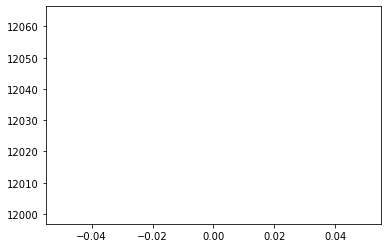

record the last path to gazebo for showing up


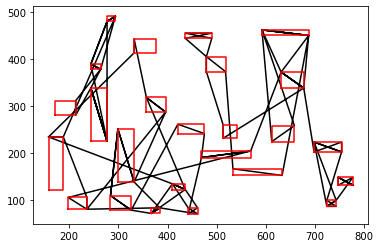

tensor([12., 18., 18.,  2., 18., 12., 12.,  7., 24., 24.,  9., 24.,  9.,  9.,
         1., 11., 10., 15., 14.,  4.,  3., 11.,  3.,  4.,  4.,  1., 19., 10.,
        19.,  3., 16., 16., 21., 21.,  0.,  8., 22., 17., 23., 17., 22.,  5.,
        23., 23.,  5.,  5., 13., 13., 13.,  6., 20.,  6.,  6., 20., 20.],
       device='cuda:0')
epoch:0, batch:200/500, reward:11357.181640625


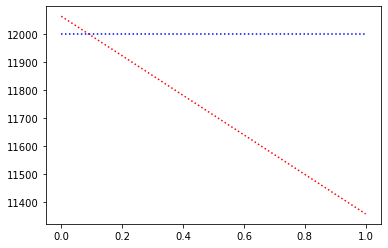

record the last path to gazebo for showing up


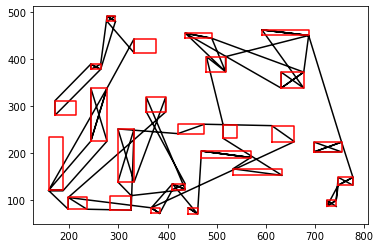

tensor([ 7., 12., 18., 18.,  2., 12., 12., 18., 24., 24., 24.,  9.,  9.,  9.,
         1., 11.,  1.,  4., 19., 19., 16.,  4.,  4.,  3., 10., 10., 16., 21.,
         3.,  3.,  8., 11., 21., 15.,  0., 22., 22., 17., 17.,  5., 23., 23.,
         5.,  5., 23., 14.,  6., 13., 20., 13.,  6., 13., 20.,  6., 20.],
       device='cuda:0')
epoch:0, batch:300/500, reward:11232.1123046875


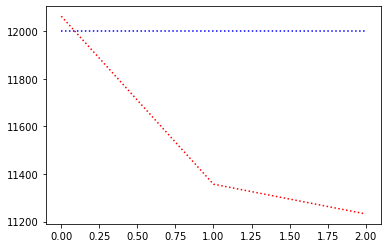

record the last path to gazebo for showing up


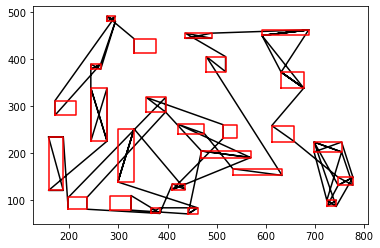

tensor([18., 12.,  7., 18., 12., 12., 18.,  2., 24., 24., 24.,  9.,  1.,  9.,
         1.,  9.,  4., 10.,  3., 16., 10., 19., 19.,  4.,  4., 16.,  3.,  3.,
        11., 11., 15., 21., 21.,  0.,  8., 17., 23., 22., 17., 22.,  5.,  5.,
         5., 23., 23., 14., 13., 13., 13., 20., 20., 20.,  6.,  6.,  6.],
       device='cuda:0')
epoch:0, batch:400/500, reward:11235.16796875


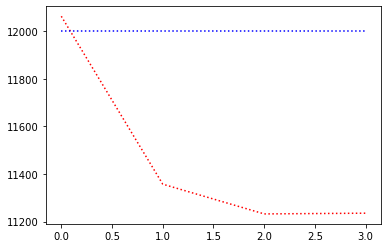

record the last path to gazebo for showing up


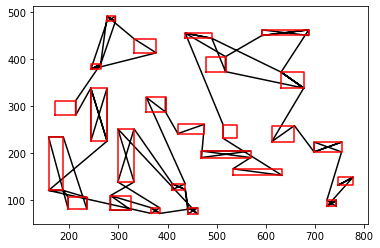

tensor([12., 12., 12., 18., 18., 18.,  7., 24.,  2., 24.,  9., 24.,  1.,  9.,
         1.,  9., 19., 19., 16., 11., 10.,  4.,  3.,  4.,  4., 16., 10.,  3.,
         3., 11., 15., 21.,  0., 21.,  8., 23., 22., 17., 17., 22.,  5., 23.,
         5.,  5., 23., 14., 20., 20., 20., 13., 13., 13.,  6.,  6.,  6.],
       device='cuda:0')
epoch:0, batch:500/500, reward:11044.5244140625


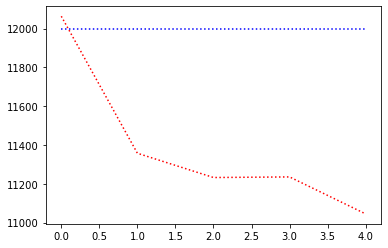

record the last path to gazebo for showing up


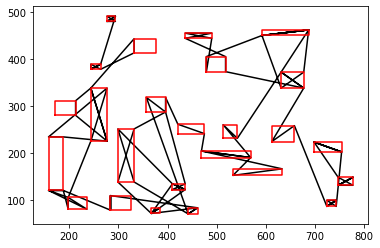

R_val =  tensor(11499.4951, device='cuda:0')
C_val =  tensor(16056.0098, device='cuda:0')
Avg Actor 11499.4951171875 --- Avg Critic 16056.009765625
My actor is going on the right road Hallelujah :) Updated
Epoch: 0, epoch time: 11.828min, tot time: 0.008day, L_actor: 11499.495, L_critic: 16056.010, update: True
Save Checkpoints
tensor([18., 18., 18.,  7., 12., 12., 12., 24.,  2., 24., 24.,  1.,  9.,  9.,
         9.,  1., 19., 10., 10., 19.,  4., 15., 11., 11., 16.,  4., 16.,  4.,
         3.,  3.,  3., 21., 21.,  0.,  8.,  5., 17., 17., 22., 23., 22.,  5.,
         5., 23., 23., 14., 13., 20.,  6.,  6., 20.,  6., 20., 13., 13.],
       device='cuda:0')
epoch:1, batch:100/500, reward:10916.8896484375


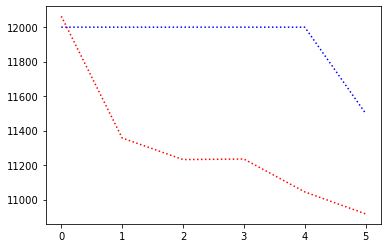

record the last path to gazebo for showing up


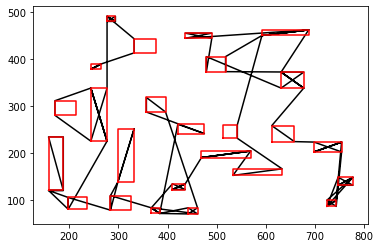

tensor([12., 12.,  7., 12., 18., 24., 24., 18.,  2., 18.,  9., 24.,  9.,  1.,
         1., 10.,  9., 10., 19.,  4., 19., 16.,  3.,  4.,  4.,  3., 11., 11.,
        15.,  3., 16., 21.,  0., 21.,  8., 22., 17., 17., 22., 23.,  5.,  5.,
        23.,  5., 23., 14., 20., 13., 20.,  6., 20.,  6.,  6., 13., 13.],
       device='cuda:0')
epoch:1, batch:200/500, reward:10827.017578125


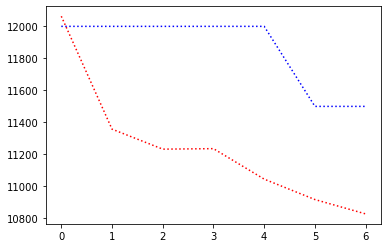

record the last path to gazebo for showing up


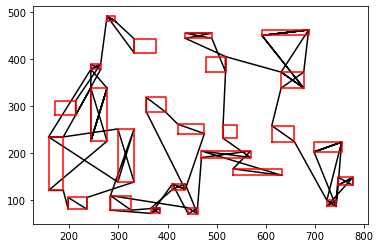

tensor([12., 12., 18., 18., 12.,  7., 18.,  2., 24.,  9., 24.,  9.,  1.,  9.,
         1., 19., 19.,  4., 10., 24., 10., 11., 11., 21.,  3.,  3.,  4.,  4.,
         3., 16., 16., 15.,  0., 21., 22.,  5., 17., 17., 23.,  8., 22., 23.,
         5.,  5., 23., 14., 20., 13., 13., 20., 13.,  6., 20.,  6.,  6.],
       device='cuda:0')
epoch:1, batch:300/500, reward:10766.4052734375


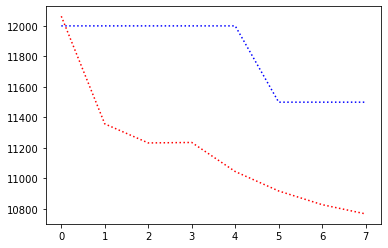

record the last path to gazebo for showing up


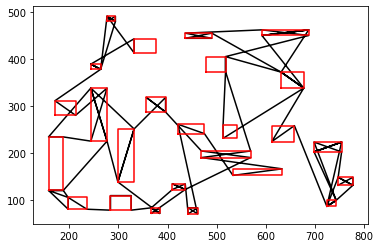

tensor([12., 12.,  7., 18.,  2., 12.,  9., 18., 11., 18.,  9.,  1., 24., 24.,
        24.,  1., 10.,  9., 10.,  4.,  3.,  4.,  4., 19., 19., 11., 15.,  8.,
         3.,  3., 16., 16., 21., 21.,  0., 22., 17., 17., 22.,  5., 23.,  5.,
         5., 23., 23., 14., 13., 13., 20.,  6.,  6., 20., 13.,  6., 20.],
       device='cuda:0')
epoch:1, batch:400/500, reward:10743.20703125


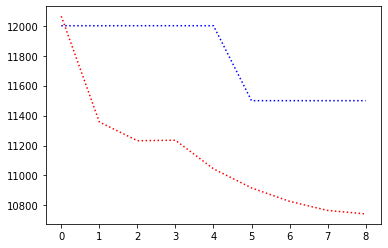

record the last path to gazebo for showing up


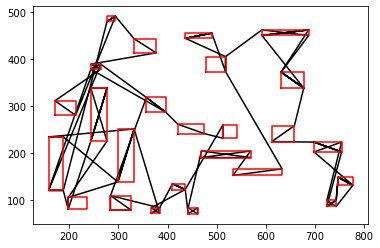

tensor([12., 12., 24., 18., 18., 12.,  7.,  2., 18., 24., 24.,  9.,  9.,  9.,
         1.,  1., 16., 16., 19., 10., 10., 19.,  4., 11., 11., 17., 15.,  3.,
         4.,  4.,  3.,  3.,  0., 21., 21.,  8., 22., 17., 22., 23.,  5., 23.,
         5.,  5., 23., 14., 13.,  6.,  6., 20., 20., 20.,  6., 13., 13.],
       device='cuda:0')
epoch:1, batch:500/500, reward:10692.892578125


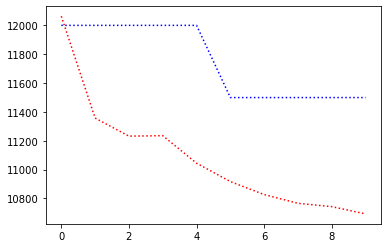

record the last path to gazebo for showing up


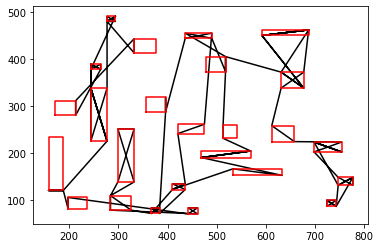

R_val =  tensor(11583.4873, device='cuda:0')
C_val =  tensor(11499.4951, device='cuda:0')
Avg Actor 11583.4873046875 --- Avg Critic 11499.4951171875
Epoch: 1, epoch time: 11.836min, tot time: 0.016day, L_actor: 11583.487, L_critic: 11499.495, update: False
Save Checkpoints
tensor([18., 24., 12.,  9., 12., 12.,  7., 18., 18., 24.,  2., 24.,  9.,  1.,
         9.,  1., 10., 11., 10., 19.,  4., 16.,  3.,  3., 19.,  4., 16.,  3.,
         4., 11., 15., 21.,  0., 21.,  8., 22., 17., 23., 22., 17., 23.,  5.,
        23.,  5., 14.,  5.,  6.,  6., 13., 13., 13., 20., 20., 20.,  6.],
       device='cuda:0')
epoch:2, batch:100/500, reward:10592.3984375


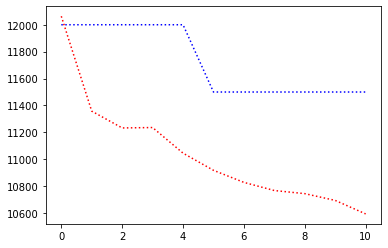

record the last path to gazebo for showing up


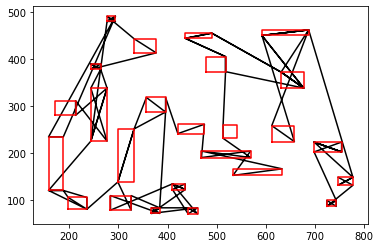

tensor([12., 12., 18., 12.,  7., 24.,  2., 18., 18., 24.,  9.,  9., 24.,  9.,
         1., 10.,  4., 19., 19.,  1.,  4., 10., 11., 11., 15., 21.,  4., 16.,
        16.,  3.,  3.,  3., 21.,  8.,  0., 22., 17., 17., 22.,  5., 23.,  5.,
         5., 23., 23., 14., 20., 13.,  6.,  6.,  6., 13., 13., 20., 20.],
       device='cuda:0')
epoch:2, batch:200/500, reward:10647.388671875


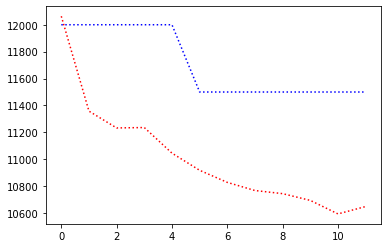

record the last path to gazebo for showing up


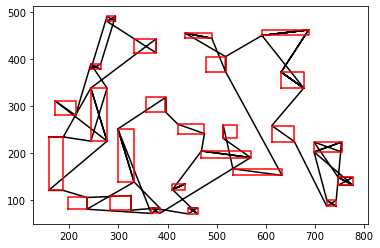

tensor([12., 12., 18., 18., 12.,  7., 18., 24.,  2., 24., 24.,  1.,  9.,  9.,
         1., 19.,  9., 19.,  4.,  3., 10., 10.,  4.,  4., 16.,  3., 16.,  3.,
        11., 11., 15.,  0., 21., 21.,  8., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 20., 20., 13., 20., 13., 13.,  6.,  6.,  6.],
       device='cuda:0')
epoch:2, batch:300/500, reward:10435.54296875


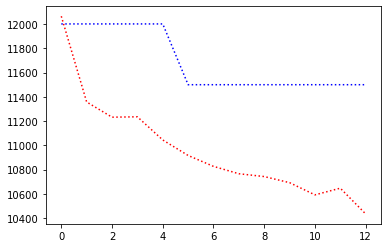

record the last path to gazebo for showing up


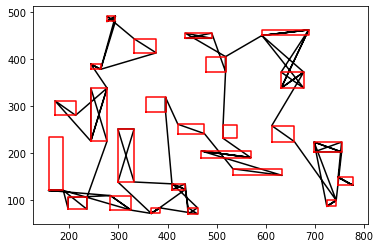

tensor([18., 12., 12.,  7., 18., 18., 12.,  2., 24., 24., 24.,  1.,  9.,  9.,
         1., 19.,  9.,  4.,  4., 19.,  4., 10., 11., 11., 15., 10., 16.,  3.,
         3., 16.,  3.,  0., 21., 21.,  8., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 20., 13., 20., 20., 13., 13.,  6.,  6.,  6.],
       device='cuda:0')
epoch:2, batch:400/500, reward:10402.615234375


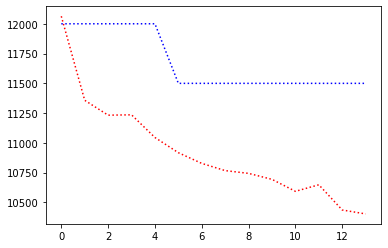

record the last path to gazebo for showing up


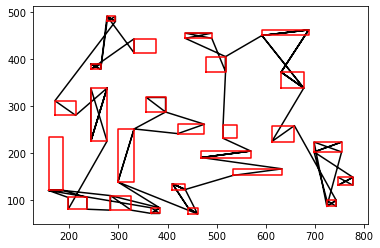

tensor([12., 18., 18.,  7., 12., 12., 18., 24.,  9., 24., 11.,  9.,  2., 24.,
         1.,  9., 19., 10.,  1., 16.,  4.,  4.,  4., 19., 16., 10., 11., 15.,
         3.,  3.,  3., 21., 21.,  0.,  8., 22., 17., 17., 22., 23.,  5., 23.,
         5., 23.,  5., 14., 13., 20.,  6., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:2, batch:500/500, reward:10402.73046875


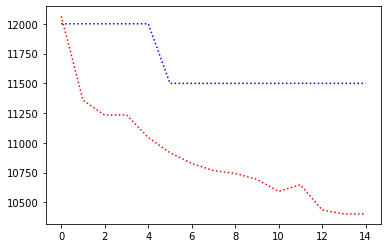

record the last path to gazebo for showing up


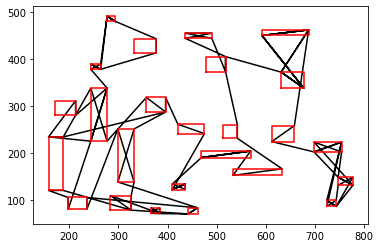

R_val =  tensor(10546.5625, device='cuda:0')
C_val =  tensor(11499.4951, device='cuda:0')
Avg Actor 10546.5625 --- Avg Critic 11499.4951171875
My actor is going on the right road Hallelujah :) Updated
Epoch: 2, epoch time: 12.077min, tot time: 0.025day, L_actor: 10546.562, L_critic: 11499.495, update: True
Save Checkpoints
tensor([18., 12., 18.,  7., 12., 18., 12.,  2., 24.,  9., 24., 24.,  1.,  9.,
         1., 19.,  9., 19., 16., 10., 11., 11., 10.,  4.,  3.,  4., 16.,  4.,
         3.,  3., 15.,  0., 21., 21.,  8., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6., 13., 13.,  6., 20.,  6., 20., 20.],
       device='cuda:0')
epoch:3, batch:100/500, reward:10146.146484375


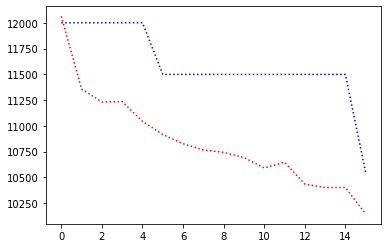

record the last path to gazebo for showing up


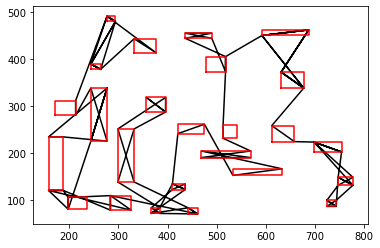

tensor([18., 12.,  7., 18., 12., 18., 12., 11., 24., 24., 24.,  1.,  9.,  9.,
         2.,  9.,  1., 19., 19.,  4.,  3., 10., 11., 10., 16., 21.,  3.,  4.,
        16.,  4.,  3., 15., 21.,  0.,  8., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6.,  6.,  6., 20., 13., 20., 20., 13.],
       device='cuda:0')
epoch:3, batch:200/500, reward:10104.77734375


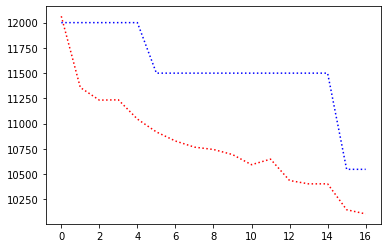

record the last path to gazebo for showing up


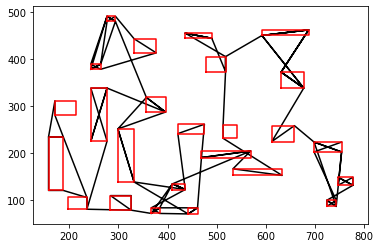

tensor([18.,  7., 12., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19.,  3.,  3., 19.,  4., 10., 11., 11., 10., 16.,  3.,  4.,
         4., 16., 15., 21., 21.,  0.,  8., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14.,  6.,  6., 20., 13., 20., 20., 13.,  6., 13.],
       device='cuda:0')
epoch:3, batch:300/500, reward:9989.6591796875


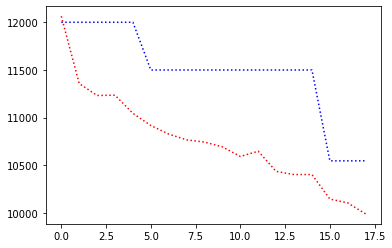

record the last path to gazebo for showing up


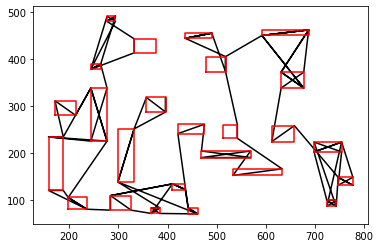

tensor([18.,  7., 12., 12.,  2., 12., 18., 24.,  9., 18., 24., 24.,  1.,  9.,
         1., 19.,  9., 19.,  4., 10., 11., 11., 10.,  4., 16.,  3., 21.,  3.,
         4., 16.,  3., 15., 21.,  0.,  8., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6., 13., 13., 20., 20., 20.,  6.,  6.],
       device='cuda:0')
epoch:3, batch:400/500, reward:9984.029296875


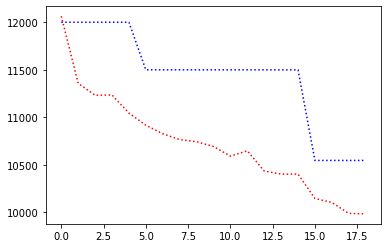

record the last path to gazebo for showing up


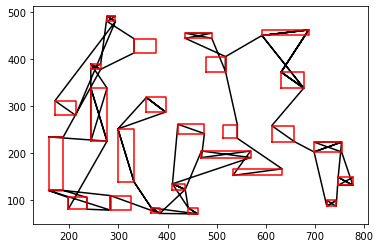

tensor([18., 12.,  7., 12., 18., 12.,  2., 18., 24.,  9., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4.,  4., 16.,
         3., 16., 15.,  0., 21., 21.,  8., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14.,  6., 13.,  6., 13., 20., 13., 20.,  6., 20.],
       device='cuda:0')
epoch:3, batch:500/500, reward:9897.953125


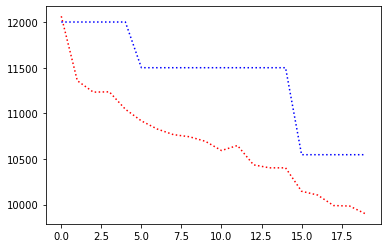

record the last path to gazebo for showing up


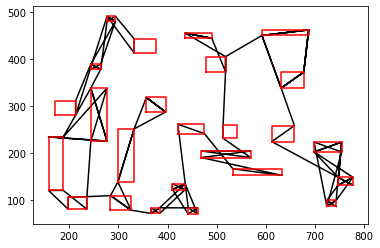

R_val =  tensor(10398.2061, device='cuda:0')
C_val =  tensor(10546.5625, device='cuda:0')
Avg Actor 10398.2060546875 --- Avg Critic 10546.5625
My actor is going on the right road Hallelujah :) Updated
Epoch: 3, epoch time: 12.009min, tot time: 0.033day, L_actor: 10398.206, L_critic: 10546.562, update: True
Save Checkpoints
tensor([18.,  7., 12., 12., 12., 18.,  2., 18., 24.,  9., 24.,  9., 24.,  1.,
         9.,  1., 19.,  3., 10., 11., 11., 10., 19.,  4.,  3.,  4.,  4., 16.,
         3., 16., 21.,  0., 15., 21.,  8., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14.,  6., 13.,  6., 13., 13.,  6., 20., 20., 20.],
       device='cuda:0')
epoch:4, batch:100/500, reward:9757.396484375


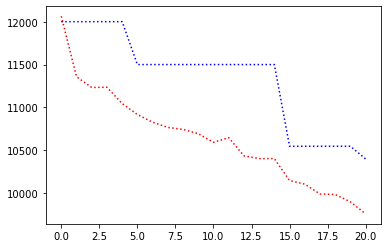

record the last path to gazebo for showing up


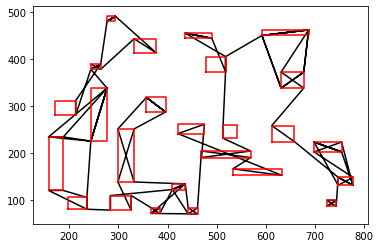

tensor([18.,  7., 12., 18., 12., 12., 18., 24.,  9.,  2., 24., 24.,  1.,  9.,
         1., 19.,  9., 19.,  4.,  3., 10., 11., 11., 10.,  4.,  4., 16.,  0.,
         3.,  3., 16., 21.,  8., 15., 21., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 13., 20., 13., 20.,  6.,  6., 20.,  6.],
       device='cuda:0')
epoch:4, batch:200/500, reward:9740.4052734375


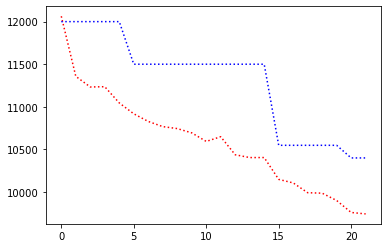

record the last path to gazebo for showing up


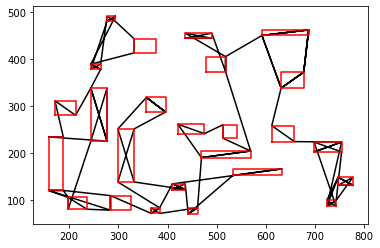

tensor([18., 12., 12.,  7., 12., 18.,  2., 18., 24.,  9., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21., 15.,  8., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20.,  6., 20., 20., 13., 13.,  6.,  6.],
       device='cuda:0')
epoch:4, batch:300/500, reward:9615.447265625


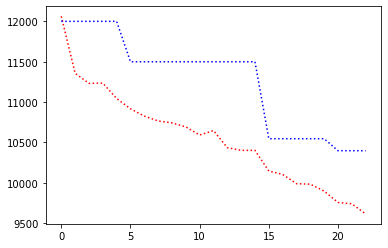

record the last path to gazebo for showing up


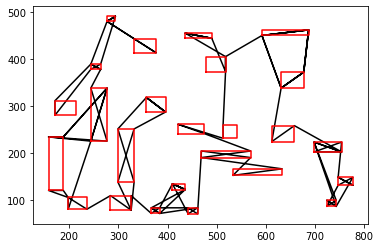

tensor([18., 12., 12.,  7., 12., 18.,  2., 18., 24.,  9., 24.,  9., 24., 19.,
         9.,  1., 10., 11., 11., 10.,  1., 19.,  4.,  3., 16.,  3., 16.,  4.,
         4., 21.,  3., 15.,  0.,  8., 21., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 13., 13.,  6.,  6.,  6., 20., 20., 20.],
       device='cuda:0')
epoch:4, batch:400/500, reward:9577.92578125


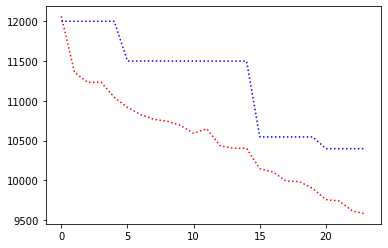

record the last path to gazebo for showing up


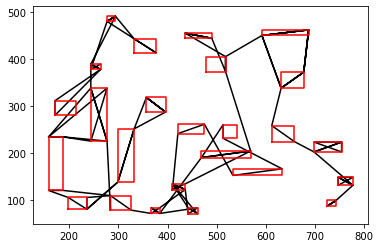

tensor([18.,  7., 18.,  2., 12., 18., 12., 12., 24.,  9., 24.,  9., 24.,  1.,
         9., 19., 10., 11., 11., 10.,  1., 19.,  4.,  4., 16.,  3.,  3., 16.,
         4.,  3.,  0., 21., 21.,  8., 15., 22., 17., 17., 22., 23.,  5., 23.,
         5., 23.,  5., 14., 13., 13., 13., 20., 20., 20.,  6.,  6.,  6.],
       device='cuda:0')
epoch:4, batch:500/500, reward:9622.474609375


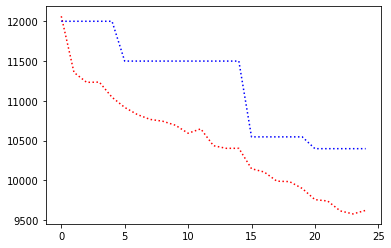

record the last path to gazebo for showing up


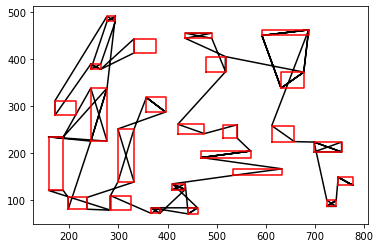

R_val =  tensor(9582.2617, device='cuda:0')
C_val =  tensor(10398.2061, device='cuda:0')
Avg Actor 9582.26171875 --- Avg Critic 10398.2060546875
My actor is going on the right road Hallelujah :) Updated
Epoch: 4, epoch time: 11.973min, tot time: 0.042day, L_actor: 9582.262, L_critic: 10398.206, update: True
Save Checkpoints
tensor([18., 12., 12., 18.,  7., 12., 18., 24.,  9., 24.,  2., 24.,  1.,  9.,
         1., 19.,  9., 19.,  4., 10., 11., 11., 10.,  4., 16.,  3.,  3.,  4.,
        16.,  3., 21., 21.,  0., 15.,  8., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14.,  6.,  6., 13., 20., 13., 13.,  6., 20., 20.],
       device='cuda:0')
epoch:5, batch:100/500, reward:9454.5654296875


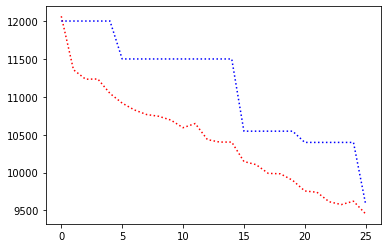

record the last path to gazebo for showing up


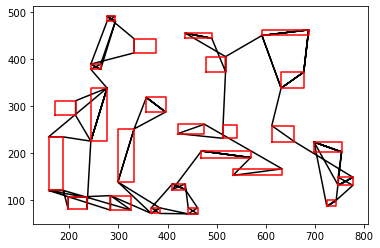

tensor([18., 12., 12.,  7., 12., 18.,  2., 18., 24.,  9., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
        16.,  4., 21., 21.,  0.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20., 13., 20., 20., 13.,  6.,  6.,  6.],
       device='cuda:0')
epoch:5, batch:200/500, reward:9352.4921875


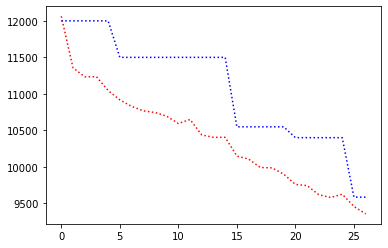

record the last path to gazebo for showing up


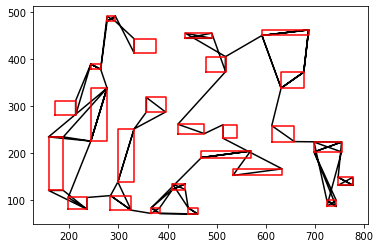

tensor([18., 12.,  7., 12., 12., 18.,  2., 18., 24.,  9., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
        16.,  4., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14.,  6., 20.,  6., 13.,  6., 20., 13., 13., 20.],
       device='cuda:0')
epoch:5, batch:300/500, reward:9232.544921875


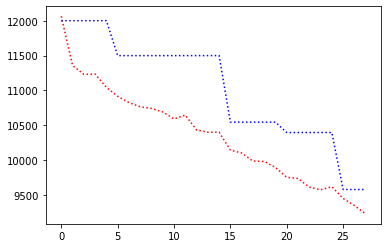

record the last path to gazebo for showing up


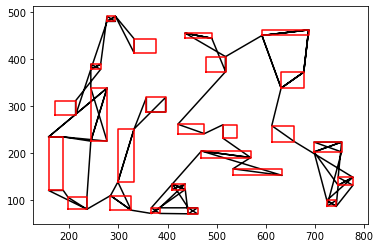

tensor([18., 12., 12., 12., 18.,  7., 18.,  2., 11.,  9., 24.,  9., 24.,  9.,
         1.,  1., 19., 10., 11., 24., 19.,  4., 10., 21.,  3.,  3.,  4., 16.,
         3.,  4., 16., 21.,  0.,  8., 15., 17., 17., 22., 22., 23.,  5., 23.,
         5., 23., 14.,  5., 20.,  6., 13.,  6., 13., 20., 13., 20.,  6.],
       device='cuda:0')
epoch:5, batch:400/500, reward:10520.744140625


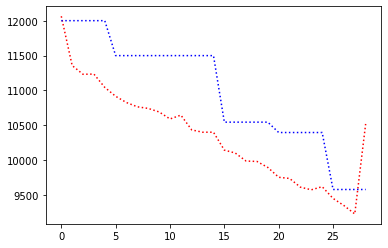

record the last path to gazebo for showing up


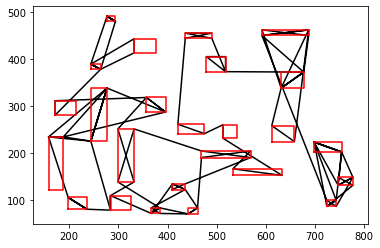

tensor([18., 12.,  7., 12., 12., 18.,  2., 18., 24.,  9., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14.,  6.,  6., 13., 13.,  6., 20., 13., 20., 20.],
       device='cuda:0')
epoch:5, batch:500/500, reward:9157.71484375


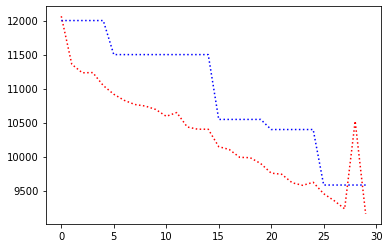

record the last path to gazebo for showing up


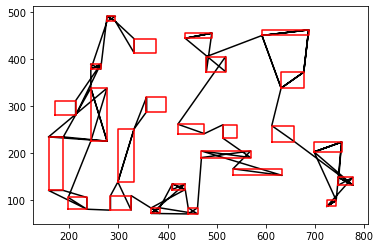

R_val =  tensor(8708.6436, device='cuda:0')
C_val =  tensor(9582.2617, device='cuda:0')
Avg Actor 8708.6435546875 --- Avg Critic 9582.26171875
My actor is going on the right road Hallelujah :) Updated
Epoch: 5, epoch time: 11.651min, tot time: 0.050day, L_actor: 8708.644, L_critic: 9582.262, update: True
Save Checkpoints
tensor([18., 12.,  7., 18., 12., 18., 12., 24.,  2., 24.,  9., 24.,  1., 10.,
         9., 11.,  9.,  1., 19., 10., 11., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 17., 17., 22., 23., 22.,  5., 23.,
         5.,  5., 23., 14., 13., 20., 20., 13., 20.,  6., 13.,  6.,  6.],
       device='cuda:0')
epoch:6, batch:100/500, reward:9085.3046875


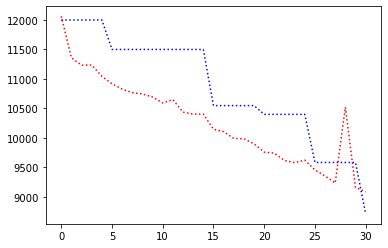

record the last path to gazebo for showing up


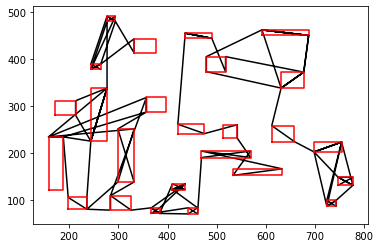

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9., 19., 10., 11., 11., 10.,  1., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20.,  6., 13., 20., 13., 20.,  6.,  6.],
       device='cuda:0')
epoch:6, batch:200/500, reward:8896.93359375


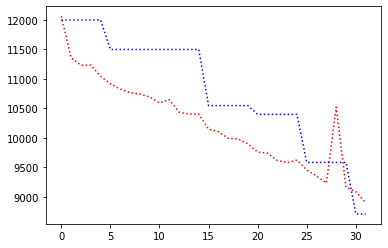

record the last path to gazebo for showing up


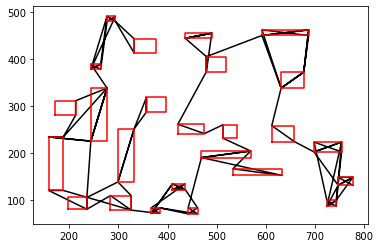

tensor([18., 12.,  7., 12., 12., 18.,  2., 18., 24.,  9., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21., 21.,  0., 15.,  8., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20.,  6.,  6., 13., 20., 13., 20.,  6.],
       device='cuda:0')
epoch:6, batch:300/500, reward:8689.482421875


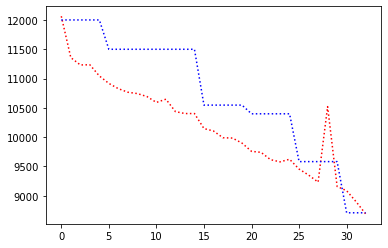

record the last path to gazebo for showing up


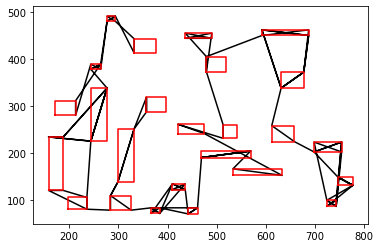

tensor([18., 12.,  7., 18., 12., 18., 12.,  2., 24.,  9., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10.,  4., 19.,  4., 16.,  3.,  3.,  4.,
        16.,  3., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20., 20., 13., 20.,  6., 13.,  6.,  6.],
       device='cuda:0')
epoch:6, batch:400/500, reward:8635.716796875


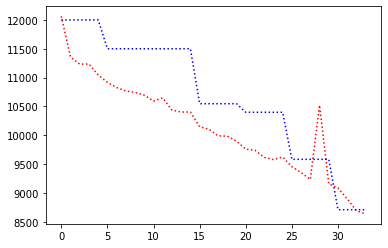

record the last path to gazebo for showing up


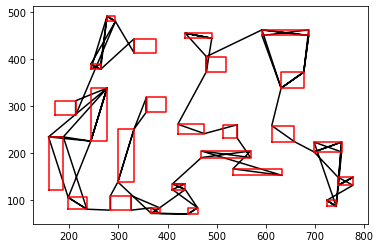

tensor([18., 12., 18.,  7., 18., 12., 12., 24.,  9.,  2., 24.,  9., 24., 19.,
         9.,  1., 10., 11., 11., 10.,  1., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14.,  6.,  6., 13.,  6., 20., 20., 13., 20., 13.],
       device='cuda:0')
epoch:6, batch:500/500, reward:8591.0244140625


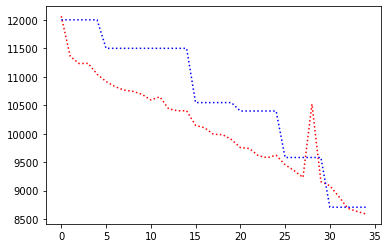

record the last path to gazebo for showing up


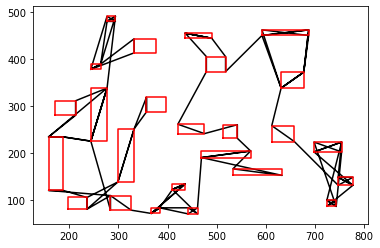

R_val =  tensor(8435.5430, device='cuda:0')
C_val =  tensor(8708.6436, device='cuda:0')
Avg Actor 8435.54296875 --- Avg Critic 8708.6435546875
My actor is going on the right road Hallelujah :) Updated
Epoch: 6, epoch time: 11.603min, tot time: 0.058day, L_actor: 8435.543, L_critic: 8708.644, update: True
Save Checkpoints
tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6., 13.,  6., 13., 20., 20.,  6., 20.],
       device='cuda:0')
epoch:7, batch:100/500, reward:8556.150390625


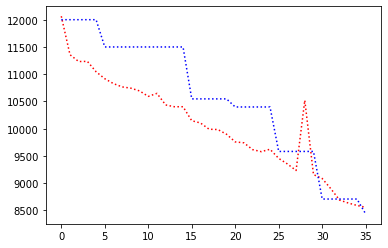

record the last path to gazebo for showing up


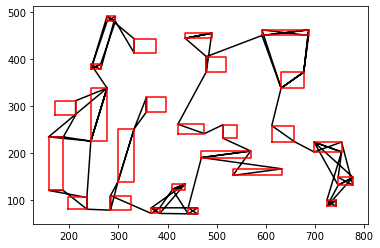

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6.,  6., 13.,  6., 20., 20., 13., 20.],
       device='cuda:0')
epoch:7, batch:200/500, reward:8553.634765625


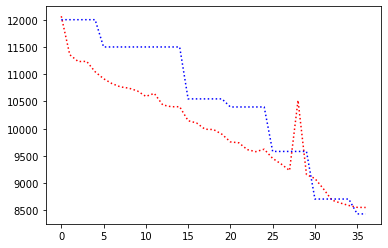

record the last path to gazebo for showing up


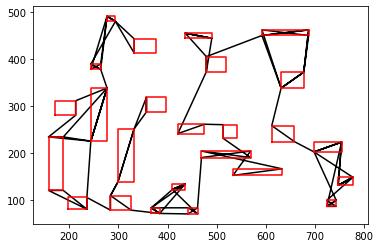

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 13., 20., 20., 13., 20.,  6.,  6.,  6.],
       device='cuda:0')
epoch:7, batch:300/500, reward:8370.05078125


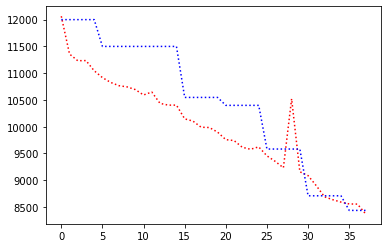

record the last path to gazebo for showing up


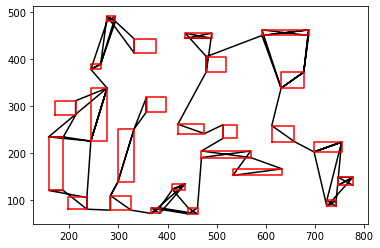

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9., 19., 10., 11., 11., 10.,  1., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0.,  6., 15., 21.,  8., 22., 17., 17., 22.,  5., 23.,
         5., 23.,  5., 23., 14., 13.,  6., 13., 20.,  6., 20., 13., 20.],
       device='cuda:0')
epoch:7, batch:400/500, reward:8329.599609375


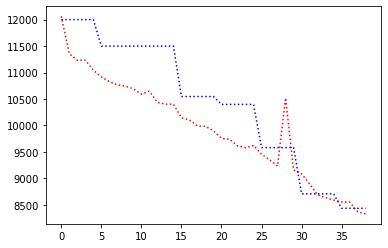

record the last path to gazebo for showing up


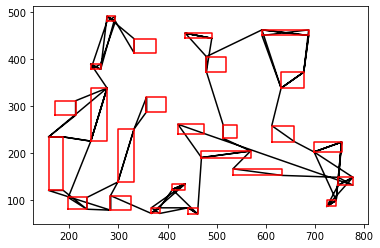

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 20.,  0., 21., 15., 21.,  8., 22., 17., 17., 22.,  5., 23.,
         5., 23.,  5., 23., 14., 20., 13., 20.,  6.,  6., 13.,  6., 13.],
       device='cuda:0')
epoch:7, batch:500/500, reward:8247.146484375


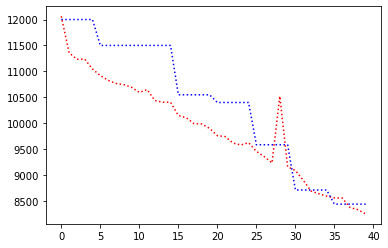

record the last path to gazebo for showing up


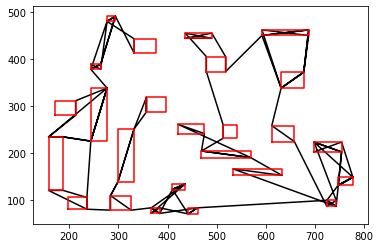

R_val =  tensor(7966.0664, device='cuda:0')
C_val =  tensor(8435.5430, device='cuda:0')
Avg Actor 7966.06640625 --- Avg Critic 8435.54296875
My actor is going on the right road Hallelujah :) Updated
Epoch: 7, epoch time: 11.561min, tot time: 0.066day, L_actor: 7966.066, L_critic: 8435.543, update: True
Save Checkpoints
tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16.,  0., 21., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14.,  6., 13.,  6., 13., 20.,  6., 20., 13., 20.],
       device='cuda:0')
epoch:8, batch:100/500, reward:8468.796875


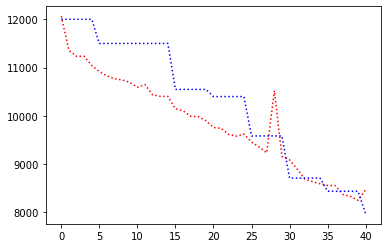

record the last path to gazebo for showing up


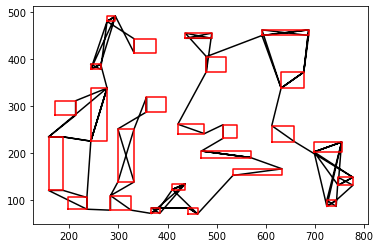

tensor([18., 12.,  7., 18., 12., 18., 12., 24., 11.,  9.,  2., 24.,  9., 24.,
         1.,  9.,  1., 19., 10., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21., 15.,  8., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14.,  6.,  6., 13.,  6., 20., 20., 13., 20., 13.],
       device='cuda:0')
epoch:8, batch:200/500, reward:8368.6015625


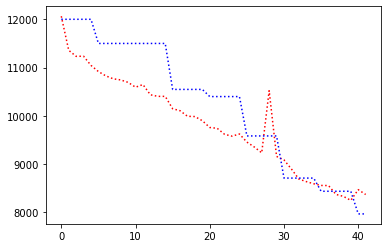

record the last path to gazebo for showing up


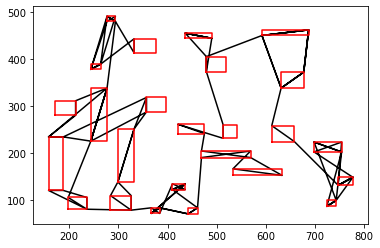

tensor([18., 12.,  7., 18., 12., 18., 12., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 20.,  6., 20., 13., 20., 13.,  6., 13.,  6.],
       device='cuda:0')
epoch:8, batch:300/500, reward:8424.61328125


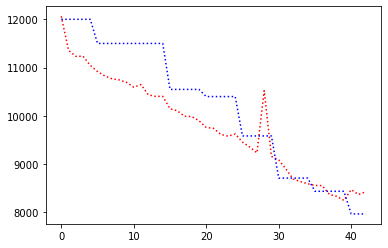

record the last path to gazebo for showing up


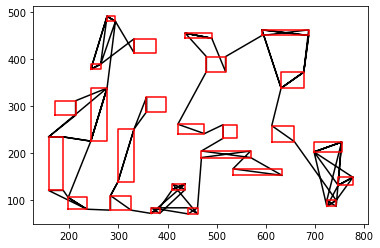

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 20., 13., 20., 13.,  6., 20.,  6., 13.,  6.],
       device='cuda:0')
epoch:8, batch:400/500, reward:8312.44140625


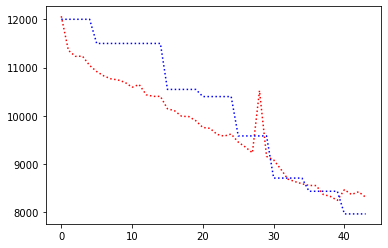

record the last path to gazebo for showing up


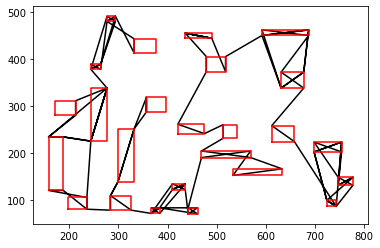

tensor([18., 12.,  7., 18., 12., 18., 12., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20., 20., 13.,  6., 20.,  6., 13.,  6.],
       device='cuda:0')
epoch:8, batch:500/500, reward:8206.0751953125


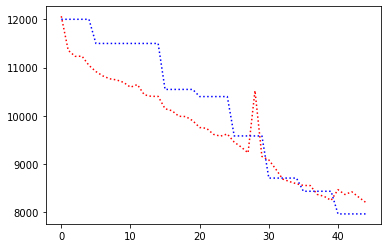

record the last path to gazebo for showing up


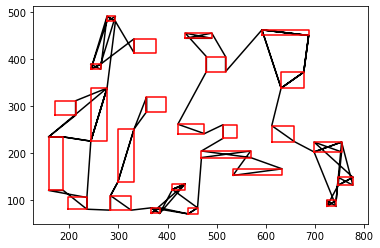

R_val =  tensor(7968.8184, device='cuda:0')
C_val =  tensor(7966.0664, device='cuda:0')
Avg Actor 7968.818359375 --- Avg Critic 7966.06640625
Epoch: 8, epoch time: 11.547min, tot time: 0.074day, L_actor: 7968.818, L_critic: 7966.066, update: False
Save Checkpoints
tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9., 24.,  9., 24.,  1.,  9.,
         1., 19., 10.,  2., 10., 19.,  4.,  3.,  4., 16.,  3.,  4., 11., 11.,
        15.,  0.,  3., 16., 21., 21.,  8., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 20., 13., 20., 13., 20.,  6., 13.,  6.,  6.],
       device='cuda:0')
epoch:9, batch:100/500, reward:8187.34326171875


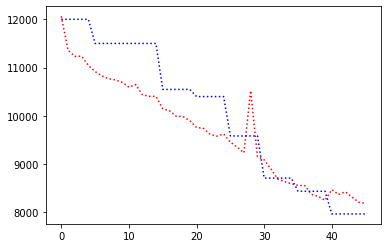

record the last path to gazebo for showing up


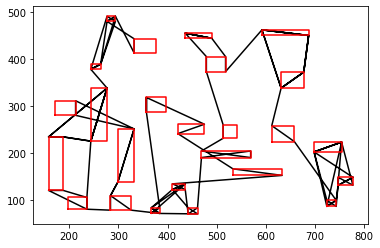

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 20.,  6., 13., 20., 13., 20.,  6., 13.,  6.],
       device='cuda:0')
epoch:9, batch:200/500, reward:8174.2255859375


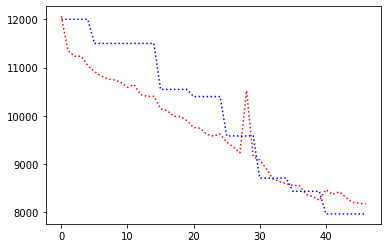

record the last path to gazebo for showing up


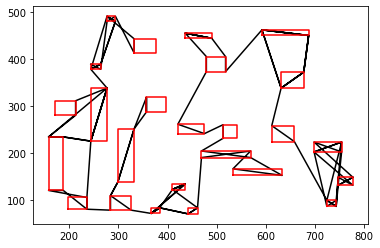

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 20.,  6., 20., 13., 13., 20.,  6., 13.,  6.],
       device='cuda:0')
epoch:9, batch:300/500, reward:8136.1474609375


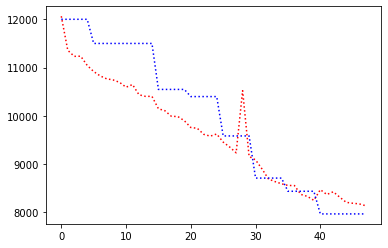

record the last path to gazebo for showing up


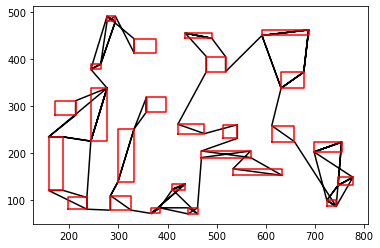

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14.,  6., 20.,  6., 13., 20., 13., 20.,  6., 13.],
       device='cuda:0')
epoch:9, batch:400/500, reward:8149.47509765625


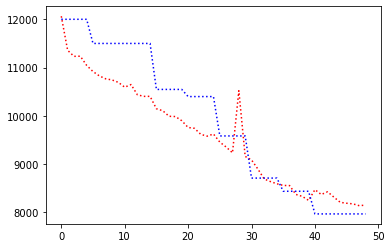

record the last path to gazebo for showing up


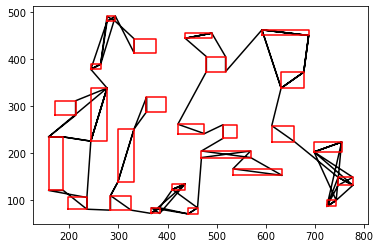

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 13., 20.,  6., 20., 13., 20.,  6.,  6.],
       device='cuda:0')
epoch:9, batch:500/500, reward:8162.380859375


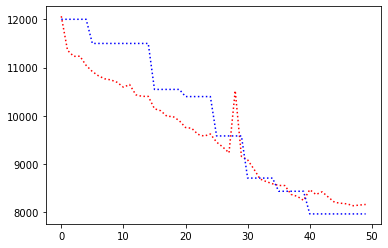

record the last path to gazebo for showing up


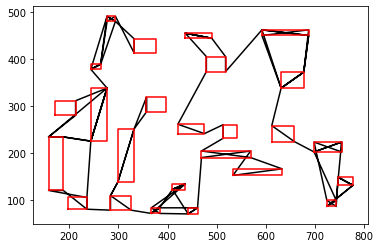

R_val =  tensor(7975.9121, device='cuda:0')
C_val =  tensor(7966.0664, device='cuda:0')
Avg Actor 7975.912109375 --- Avg Critic 7966.06640625
Epoch: 9, epoch time: 11.524min, tot time: 0.082day, L_actor: 7975.912, L_critic: 7966.066, update: False
Save Checkpoints
tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 20.,  6., 20., 13., 20.,  6., 13.,  6., 13.],
       device='cuda:0')
epoch:10, batch:100/500, reward:8102.23046875


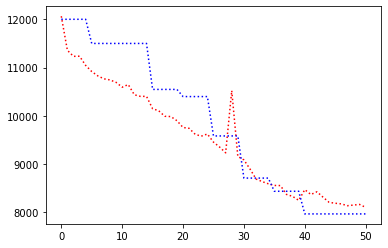

record the last path to gazebo for showing up


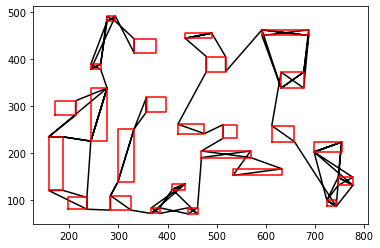

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20.,  6., 20., 13., 20.,  6., 13.,  6.],
       device='cuda:0')
epoch:10, batch:200/500, reward:8101.150390625


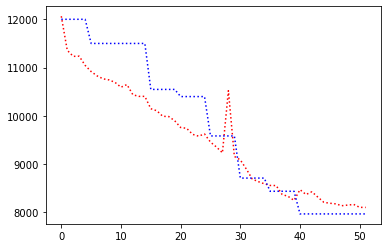

record the last path to gazebo for showing up


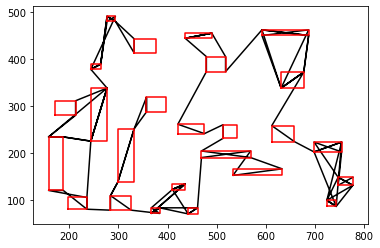

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20., 20., 13., 20.,  6., 13.,  6.,  6.],
       device='cuda:0')
epoch:10, batch:300/500, reward:8085.99951171875


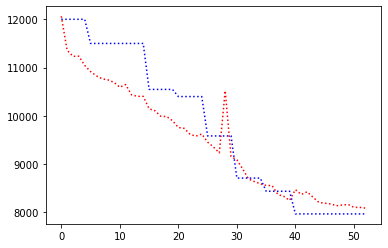

record the last path to gazebo for showing up


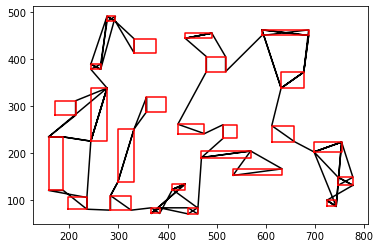

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20.,  6., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:10, batch:400/500, reward:8075.107421875


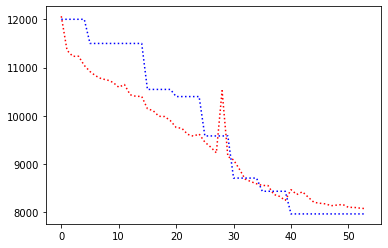

record the last path to gazebo for showing up


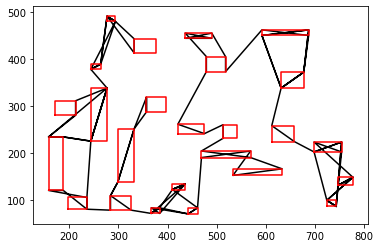

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20.,  6., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:10, batch:500/500, reward:8066.84375


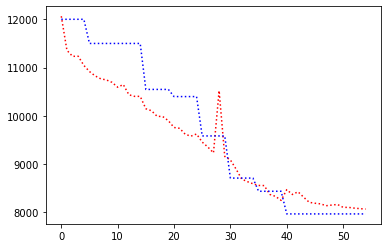

record the last path to gazebo for showing up


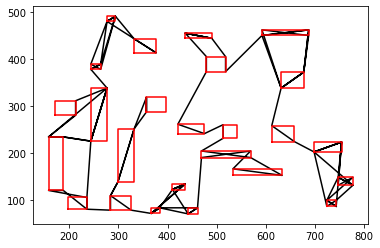

R_val =  tensor(7997.7524, device='cuda:0')
C_val =  tensor(7966.0664, device='cuda:0')
Avg Actor 7997.75244140625 --- Avg Critic 7966.06640625
Epoch: 10, epoch time: 11.567min, tot time: 0.090day, L_actor: 7997.752, L_critic: 7966.066, update: False
Save Checkpoints
tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14.,  6., 13., 20.,  6., 13., 20., 13.,  6., 20.],
       device='cuda:0')
epoch:11, batch:100/500, reward:8050.861328125


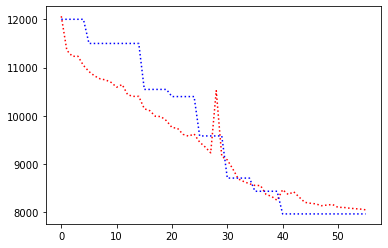

record the last path to gazebo for showing up


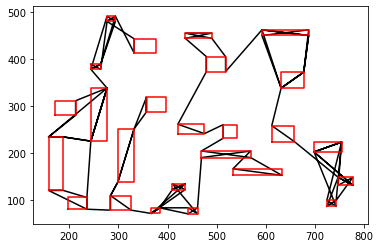

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20.,  6., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:11, batch:200/500, reward:8042.5869140625


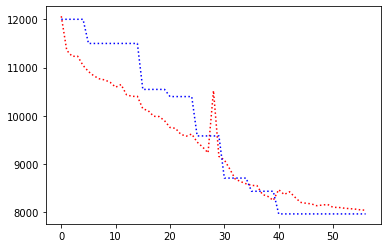

record the last path to gazebo for showing up


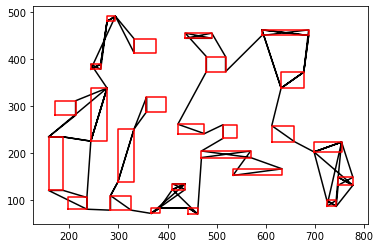

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20.,  6., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:11, batch:300/500, reward:8024.63232421875


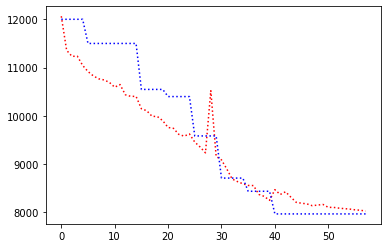

record the last path to gazebo for showing up


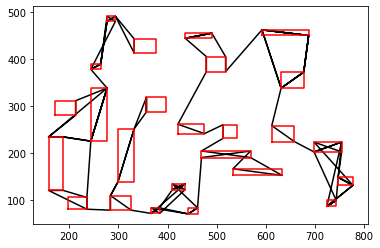

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20.,  6., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:11, batch:400/500, reward:8039.9287109375


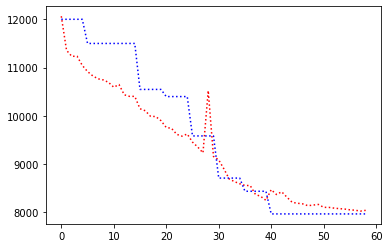

record the last path to gazebo for showing up


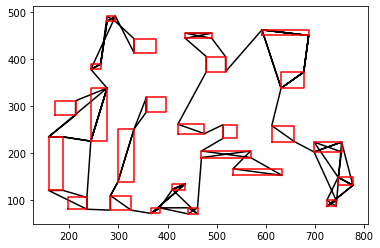

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20.,  6., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:11, batch:500/500, reward:8009.2880859375


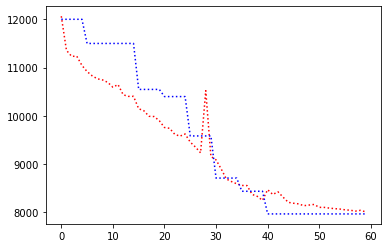

record the last path to gazebo for showing up


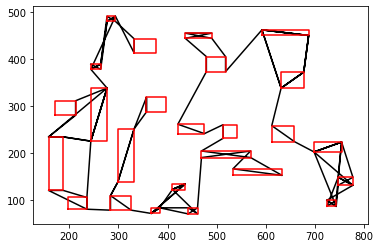

R_val =  tensor(7945.1509, device='cuda:0')
C_val =  tensor(7966.0664, device='cuda:0')
Avg Actor 7945.15087890625 --- Avg Critic 7966.06640625
My actor is going on the right road Hallelujah :) Updated
Epoch: 11, epoch time: 11.571min, tot time: 0.098day, L_actor: 7945.151, L_critic: 7966.066, update: True
Save Checkpoints
tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20.,  6., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:12, batch:100/500, reward:8063.4794921875


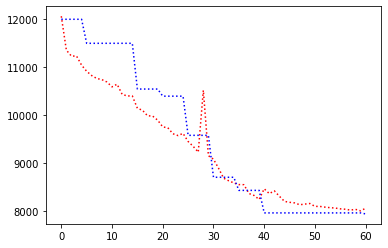

record the last path to gazebo for showing up


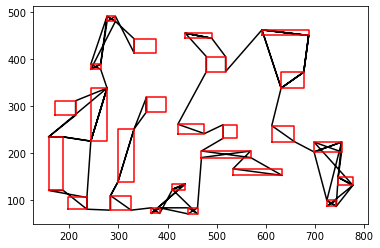

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 20.,  6., 20., 13., 20.,  6., 13.,  6., 13.],
       device='cuda:0')
epoch:12, batch:200/500, reward:7995.8857421875


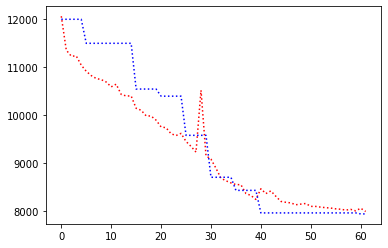

record the last path to gazebo for showing up


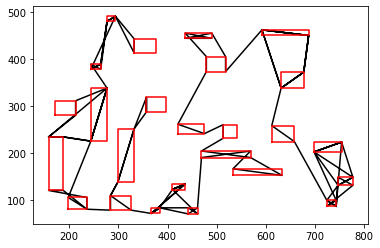

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20.,  6., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:12, batch:300/500, reward:8017.4130859375


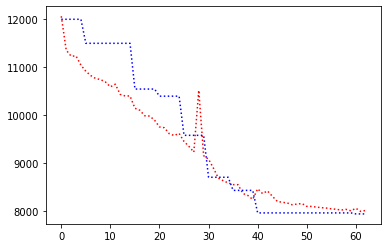

record the last path to gazebo for showing up


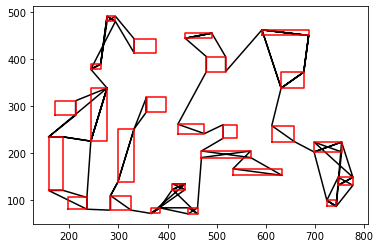

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20.,  6., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:12, batch:400/500, reward:7978.7490234375


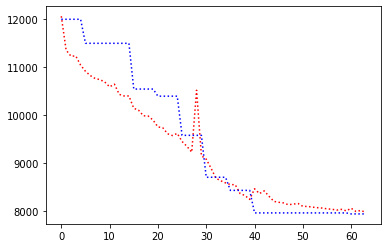

record the last path to gazebo for showing up


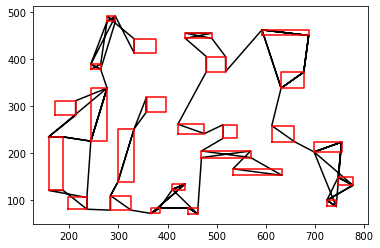

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20.,  6.,  6., 13.,  6., 20., 13., 20.],
       device='cuda:0')
epoch:12, batch:500/500, reward:8161.58203125


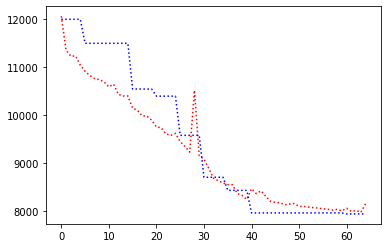

record the last path to gazebo for showing up


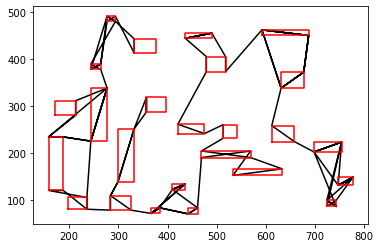

R_val =  tensor(8127.7197, device='cuda:0')
C_val =  tensor(7945.1509, device='cuda:0')
Avg Actor 8127.7197265625 --- Avg Critic 7945.15087890625
Epoch: 12, epoch time: 11.652min, tot time: 0.106day, L_actor: 8127.720, L_critic: 7945.151, update: False
Save Checkpoints
tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6., 20., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:13, batch:100/500, reward:8139.517578125


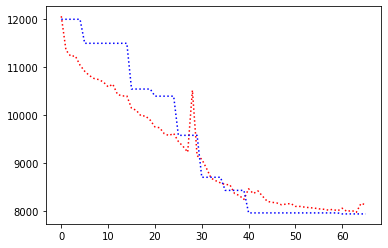

record the last path to gazebo for showing up


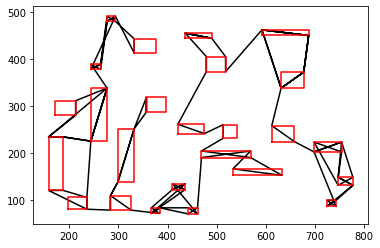

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14.,  6., 20., 20., 13.,  6., 13.,  6., 20., 13.],
       device='cuda:0')
epoch:13, batch:200/500, reward:8222.904296875


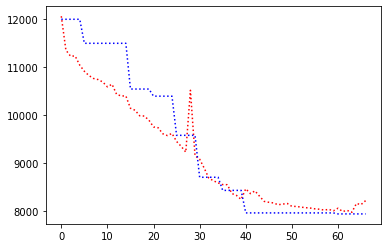

record the last path to gazebo for showing up


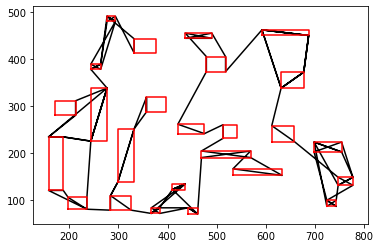

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20., 20., 13.,  6., 20.,  6., 13.,  6.],
       device='cuda:0')
epoch:13, batch:300/500, reward:8184.9912109375


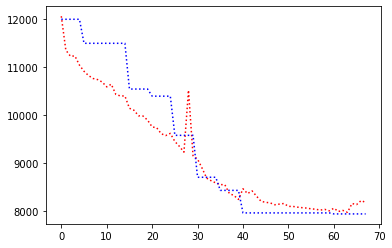

record the last path to gazebo for showing up


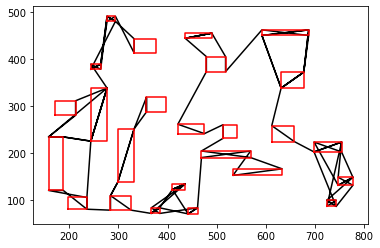

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20., 20., 13.,  6.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:13, batch:400/500, reward:8165.361328125


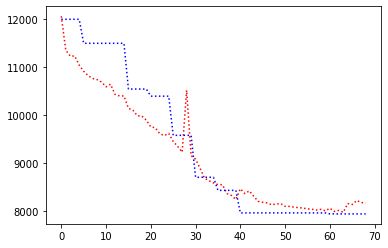

record the last path to gazebo for showing up


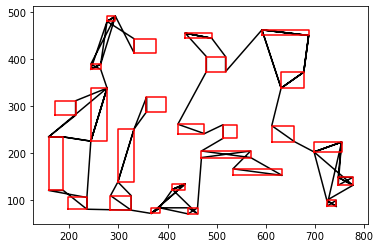

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6., 20., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:13, batch:500/500, reward:8127.53173828125


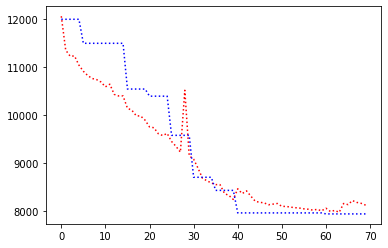

record the last path to gazebo for showing up


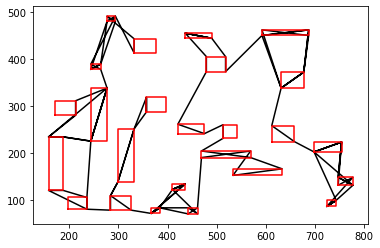

R_val =  tensor(8119.8242, device='cuda:0')
C_val =  tensor(7945.1509, device='cuda:0')
Avg Actor 8119.82421875 --- Avg Critic 7945.15087890625
Epoch: 13, epoch time: 11.776min, tot time: 0.114day, L_actor: 8119.824, L_critic: 7945.151, update: False
Save Checkpoints
tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20., 20., 13.,  6., 20.,  6., 13.,  6.],
       device='cuda:0')
epoch:14, batch:100/500, reward:8151.17236328125


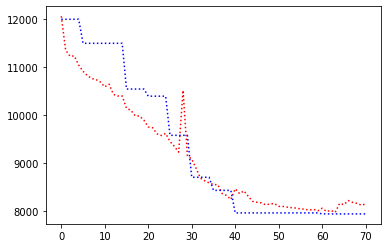

record the last path to gazebo for showing up


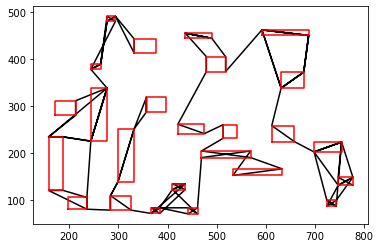

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6., 20., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:14, batch:200/500, reward:8127.7666015625


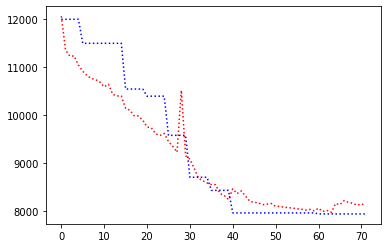

record the last path to gazebo for showing up


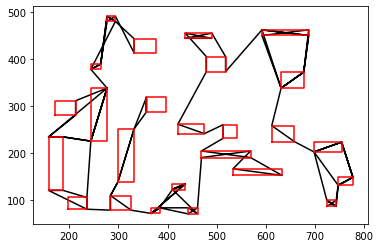

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6., 20., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:14, batch:300/500, reward:8142.78857421875


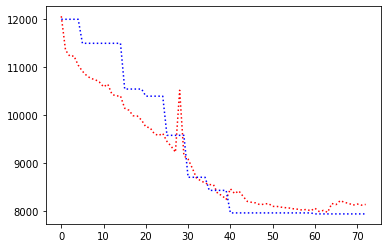

record the last path to gazebo for showing up


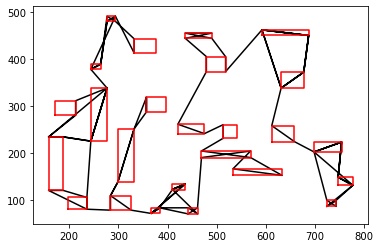

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20., 20., 13.,  6., 20.,  6., 13.,  6.],
       device='cuda:0')
epoch:14, batch:400/500, reward:8111.7607421875


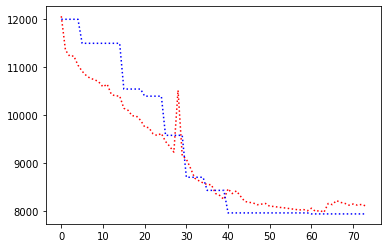

record the last path to gazebo for showing up


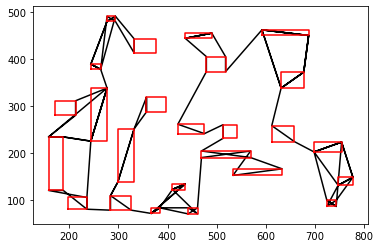

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6.,  6., 13.,  6., 20., 13., 20., 20.],
       device='cuda:0')
epoch:14, batch:500/500, reward:8096.619140625


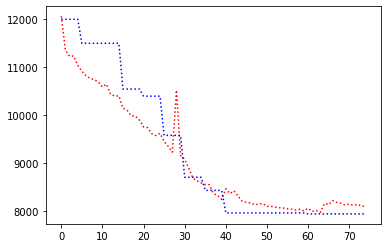

record the last path to gazebo for showing up


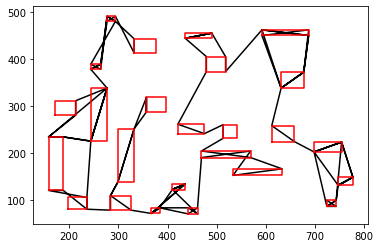

R_val =  tensor(7951.4277, device='cuda:0')
C_val =  tensor(7945.1509, device='cuda:0')
Avg Actor 7951.427734375 --- Avg Critic 7945.15087890625
Epoch: 14, epoch time: 11.878min, tot time: 0.123day, L_actor: 7951.428, L_critic: 7945.151, update: False
Save Checkpoints
tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23., 23.,  5., 14., 13., 20.,  6., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:15, batch:100/500, reward:8146.7841796875


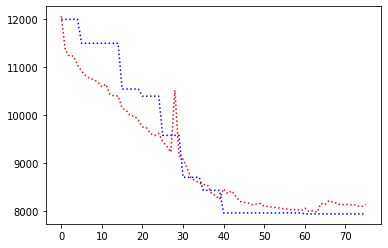

record the last path to gazebo for showing up


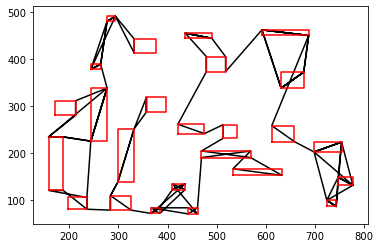

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6.,  6., 13.,  6., 20., 13., 20., 20.],
       device='cuda:0')
epoch:15, batch:200/500, reward:8104.763671875


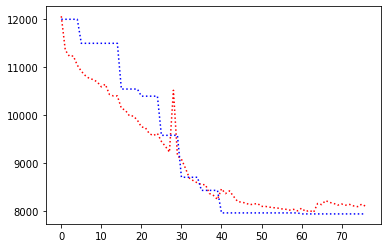

record the last path to gazebo for showing up


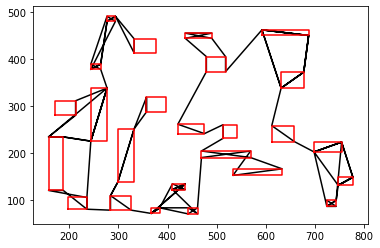

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6.,  6., 13.,  6., 20., 13., 20., 20.],
       device='cuda:0')
epoch:15, batch:300/500, reward:8063.89599609375


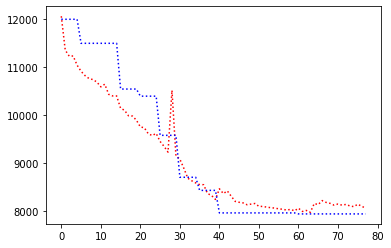

record the last path to gazebo for showing up


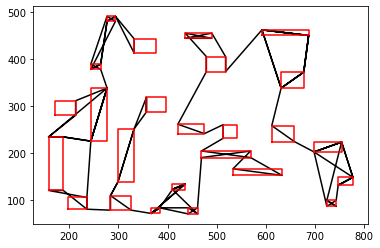

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6., 20.,  6., 13.,  6., 20., 13., 20.],
       device='cuda:0')
epoch:15, batch:400/500, reward:8080.34912109375


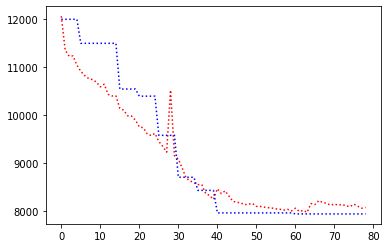

record the last path to gazebo for showing up


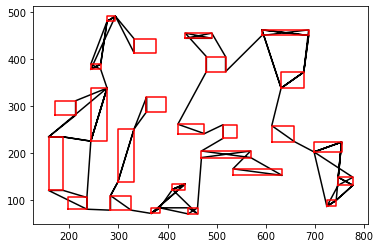

tensor([18., 12.,  7., 12., 18., 18., 12., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13., 20., 20., 13.,  6.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:15, batch:500/500, reward:8092.337890625


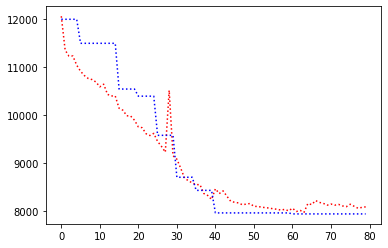

record the last path to gazebo for showing up


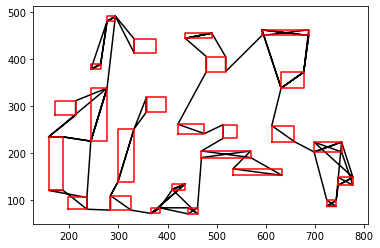

R_val =  tensor(8115.1978, device='cuda:0')
C_val =  tensor(7945.1509, device='cuda:0')
Avg Actor 8115.19775390625 --- Avg Critic 7945.15087890625
Epoch: 15, epoch time: 11.822min, tot time: 0.131day, L_actor: 8115.198, L_critic: 7945.151, update: False
Save Checkpoints
tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6., 20., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:16, batch:100/500, reward:8033.17529296875


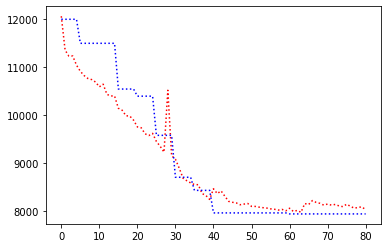

record the last path to gazebo for showing up


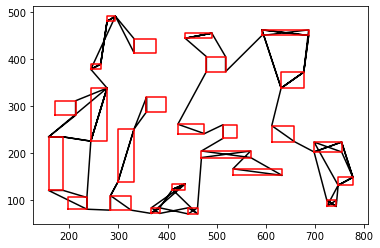

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6., 20., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:16, batch:200/500, reward:8066.1142578125


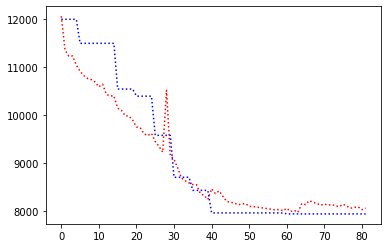

record the last path to gazebo for showing up


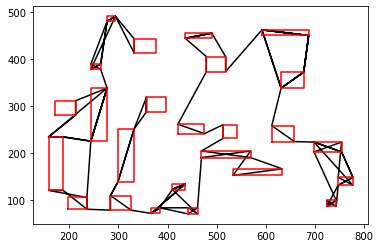

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6., 20., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:16, batch:300/500, reward:8053.40771484375


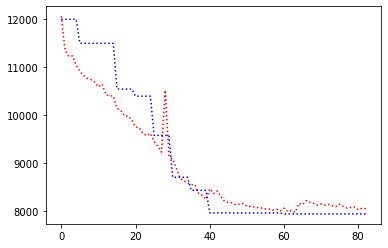

record the last path to gazebo for showing up


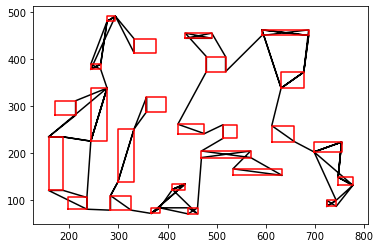

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6., 20., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:16, batch:400/500, reward:8029.86669921875


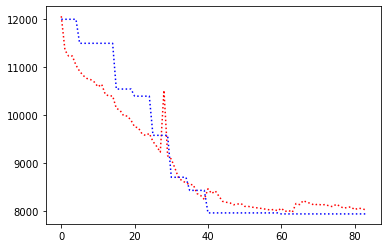

record the last path to gazebo for showing up


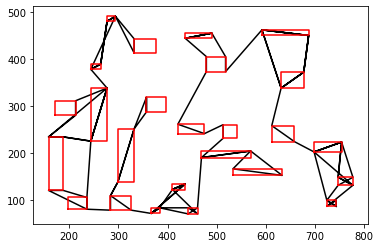

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6., 20., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:16, batch:500/500, reward:8041.98974609375


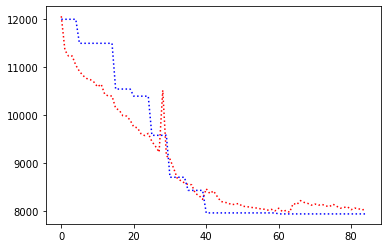

record the last path to gazebo for showing up


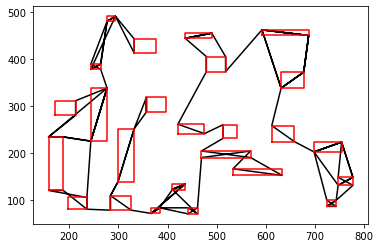

R_val =  tensor(7941.6318, device='cuda:0')
C_val =  tensor(7945.1509, device='cuda:0')
Avg Actor 7941.6318359375 --- Avg Critic 7945.15087890625
My actor is going on the right road Hallelujah :) Updated
Epoch: 16, epoch time: 11.836min, tot time: 0.139day, L_actor: 7941.632, L_critic: 7945.151, update: True
Save Checkpoints
tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6., 20., 20., 13.,  6., 13.,  6., 20.],
       device='cuda:0')
epoch:17, batch:100/500, reward:7992.8681640625


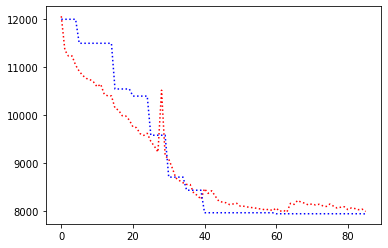

record the last path to gazebo for showing up


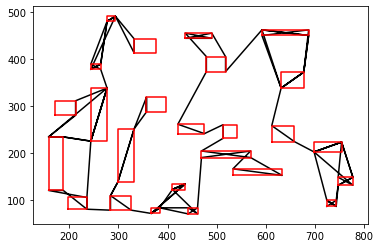

tensor([18., 12.,  7., 12., 18., 12., 18., 24.,  9.,  2., 24.,  9., 24.,  1.,
         9.,  1., 19., 10., 11., 11., 10., 19.,  4.,  3.,  3.,  4., 16.,  3.,
         4., 16., 21.,  0., 21.,  8., 15., 22., 17., 17., 22.,  5., 23.,  5.,
        23.,  5., 23., 14., 13.,  6.,  6., 13.,  6., 20., 13., 20., 20.],
       device='cuda:0')
epoch:17, batch:200/500, reward:8003.208984375


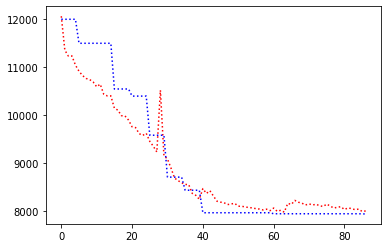

record the last path to gazebo for showing up


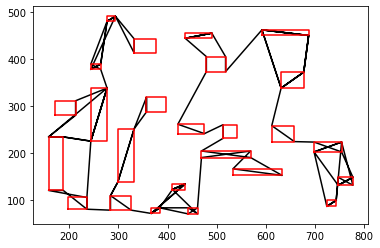

tensor([ 1., 19.,  4.,  4., 19.,  1.,  4., 10.,  9., 24.,  9., 24.,  9., 10.,
         2.,  7., 24., 18., 18., 18., 16., 16.,  3.,  3.,  3., 22., 17., 17.,
        11., 11., 12., 12., 12.,  5.,  5.,  5., 22., 15., 21., 21., 23., 23.,
        23.,  6.,  8.,  0., 14., 20., 20., 20.,  6., 13.,  6., 13., 13.],
       device='cuda:0')
epoch:17, batch:300/500, reward:12940.7734375


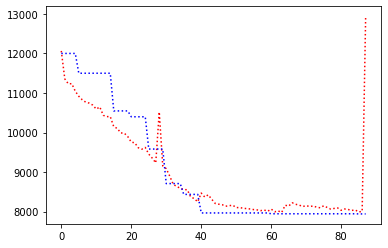

record the last path to gazebo for showing up


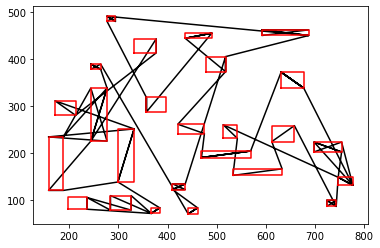

tensor([12.,  9.,  1., 16.,  2.,  9., 10., 24.,  1.,  4., 10.,  4.,  9., 19.,
         3., 16., 19., 24., 11.,  4., 24.,  3., 21.,  3., 18., 15., 21., 18.,
        11., 18.,  7.,  8.,  0., 12., 12., 17., 22., 22., 13., 17., 20., 14.,
        23., 13.,  5., 23., 13.,  6., 23., 20.,  6.,  6., 20.,  5.,  5.],
       device='cuda:0')
epoch:17, batch:400/500, reward:13727.15625


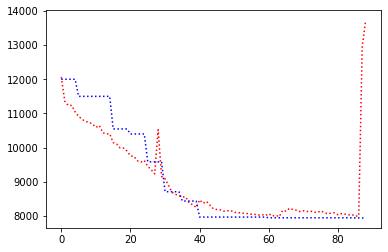

record the last path to gazebo for showing up


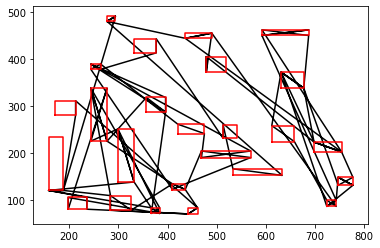

tensor([ 1.,  1., 19., 19.,  4.,  9.,  4.,  9.,  9., 10.,  2., 10., 24.,  4.,
        24., 18., 18., 11., 24.,  3.,  3.,  3., 18., 16., 21., 16., 12., 11.,
        12., 12.,  7., 15., 21., 17.,  6.,  8., 20.,  5., 14., 20., 20.,  5.,
        13., 17.,  5.,  6., 23., 22., 13.,  0., 23., 22., 23.,  6., 13.],
       device='cuda:0')
epoch:17, batch:500/500, reward:13369.107421875


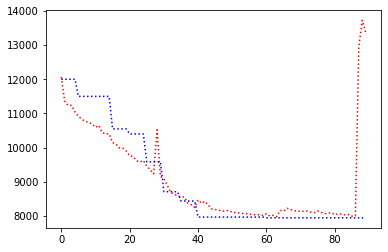

record the last path to gazebo for showing up


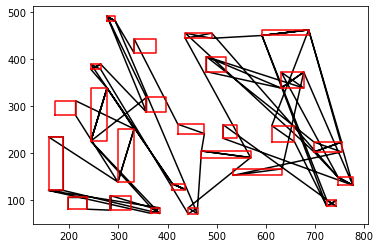

R_val =  tensor(12953.7910, device='cuda:0')
C_val =  tensor(7941.6318, device='cuda:0')
Avg Actor 12953.791015625 --- Avg Critic 7941.6318359375
Epoch: 17, epoch time: 11.790min, tot time: 0.147day, L_actor: 12953.791, L_critic: 7941.632, update: False
Save Checkpoints
tensor([ 1.,  1.,  9.,  4.,  4.,  9., 19.,  4.,  9., 16., 19.,  3.,  3.,  2.,
        10.,  3., 16., 10., 24., 24., 11., 24., 18., 18., 18., 11., 12., 12.,
        12.,  7., 15., 21., 21.,  8., 14., 13.,  0., 13.,  5.,  5., 22., 13.,
        23.,  6.,  5.,  6., 17., 23., 17., 23., 22.,  6., 20., 20., 20.],
       device='cuda:0')
epoch:18, batch:100/500, reward:13274.84375


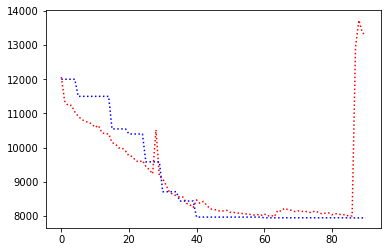

record the last path to gazebo for showing up


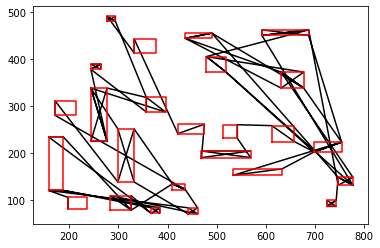

tensor([ 1.,  1.,  4.,  3., 19.,  9.,  4., 19., 16., 10.,  9.,  4., 24.,  9.,
         3., 16.,  3., 24., 24., 10., 18., 11., 18.,  2., 11.,  7., 12., 18.,
        12., 12., 17., 21., 21., 15., 23.,  5., 14.,  6.,  5., 23., 17., 22.,
        20., 23., 22.,  5.,  8.,  0.,  6.,  6., 13., 20., 13., 20., 13.],
       device='cuda:0')
epoch:18, batch:200/500, reward:12475.5810546875


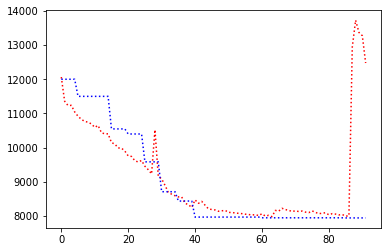

record the last path to gazebo for showing up


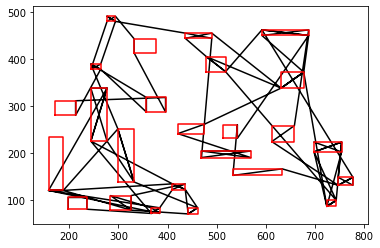

tensor([ 1.,  1., 10., 19.,  4.,  9., 19., 10.,  2.,  9.,  4.,  3.,  4., 16.,
         3.,  9.,  3., 16., 24., 11., 24., 18., 18., 18.,  7., 24., 12., 11.,
        17., 12., 12., 17.,  5., 15., 21., 21., 22., 20.,  6., 14.,  6.,  6.,
         0., 13., 20., 23.,  8., 13., 22.,  5., 23.,  5., 23., 20., 13.],
       device='cuda:0')
epoch:18, batch:300/500, reward:12167.955078125


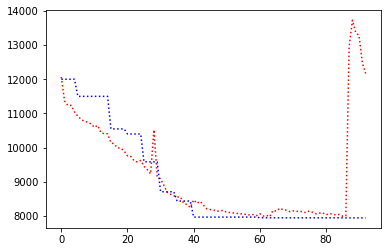

record the last path to gazebo for showing up


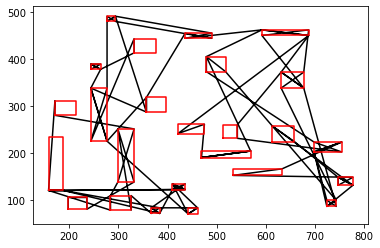

tensor([ 1.,  1.,  4.,  4., 19.,  9., 16.,  4., 10., 16., 19.,  3.,  3., 10.,
         9.,  3.,  9.,  2., 11., 11., 18.,  7., 24., 18., 24., 24., 18., 12.,
        12., 12., 17., 15., 21., 21.,  5.,  5., 17., 22., 22.,  5., 23.,  0.,
         8., 23., 14., 20., 13., 23., 20., 13., 13., 20.,  6.,  6.,  6.],
       device='cuda:0')
epoch:18, batch:400/500, reward:12137.9345703125


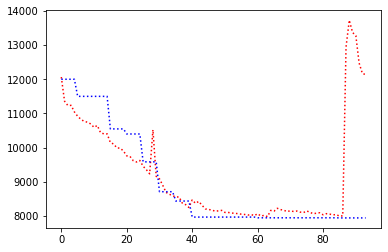

record the last path to gazebo for showing up


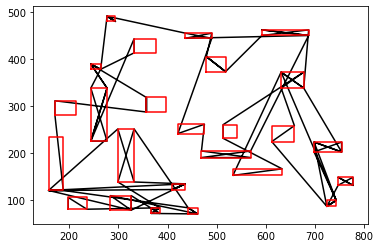

tensor([ 1., 19., 19.,  1.,  4.,  3.,  3.,  9., 16.,  4.,  3.,  4., 10., 10.,
         9., 24., 16.,  9., 24., 24.,  2., 11., 11., 18., 18., 18., 12.,  7.,
        12., 12., 17., 15., 21., 21.,  8., 23., 14., 23.,  0.,  5., 20., 13.,
        17.,  5.,  5., 22.,  6., 23., 22., 13., 13.,  6.,  6., 20., 20.],
       device='cuda:0')
epoch:18, batch:500/500, reward:11901.74609375


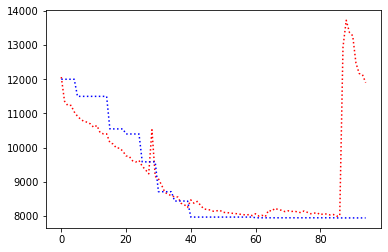

record the last path to gazebo for showing up


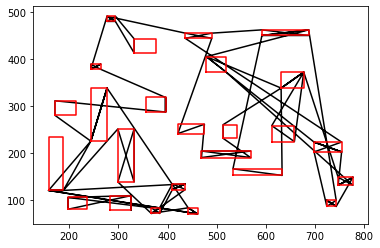

R_val =  tensor(11627.1250, device='cuda:0')
C_val =  tensor(7941.6318, device='cuda:0')
Avg Actor 11627.125 --- Avg Critic 7941.6318359375
Epoch: 18, epoch time: 11.736min, tot time: 0.156day, L_actor: 11627.125, L_critic: 7941.632, update: False
Save Checkpoints
tensor([ 1.,  1.,  4.,  9.,  4., 16.,  4.,  3.,  3., 19.,  3., 19.,  9., 10.,
        16., 10.,  9., 24., 24.,  2., 11., 24., 18., 11., 18., 18., 12., 12.,
        12.,  7., 15., 21., 21., 17., 17., 22., 22.,  5.,  5.,  5.,  8.,  0.,
        23., 20.,  6., 14., 23., 23.,  6.,  6., 20., 13., 13., 20., 13.],
       device='cuda:0')
epoch:19, batch:100/500, reward:11748.939453125


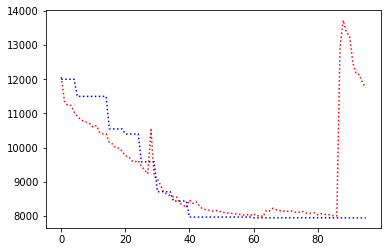

record the last path to gazebo for showing up


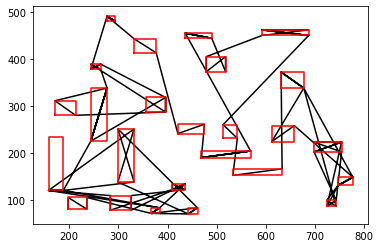

tensor([ 1.,  1., 19., 10.,  4.,  3., 16., 19.,  4.,  3., 16.,  4.,  3., 10.,
         2., 11., 24.,  9., 24.,  7., 24.,  9.,  9., 18., 18., 18., 11., 15.,
        21., 21., 17., 12., 12., 12., 17., 22., 22.,  5.,  5.,  5., 23.,  8.,
         0., 23., 23., 14., 13.,  6., 13., 13., 20., 20.,  6., 20.,  6.],
       device='cuda:0')
epoch:19, batch:200/500, reward:11628.44921875


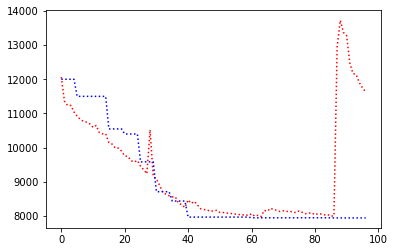

record the last path to gazebo for showing up


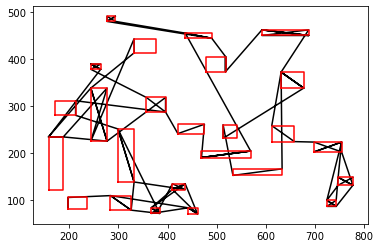

tensor([ 1.,  1.,  9.,  4., 16.,  3.,  4.,  4., 19.,  9., 19., 10., 10., 24.,
         3.,  9., 24., 18., 24., 16.,  3.,  2.,  7., 11., 18., 11., 18., 12.,
        12., 17., 15., 21., 21., 23., 17., 12., 22.,  5., 22.,  5.,  5., 23.,
        23.,  8.,  0., 14., 13., 20.,  6., 13., 13.,  6., 20., 20.,  6.],
       device='cuda:0')
epoch:19, batch:300/500, reward:11446.404296875


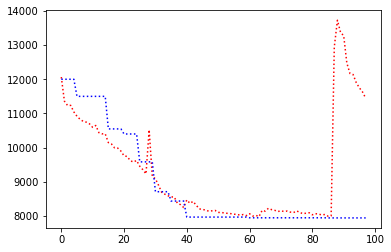

record the last path to gazebo for showing up


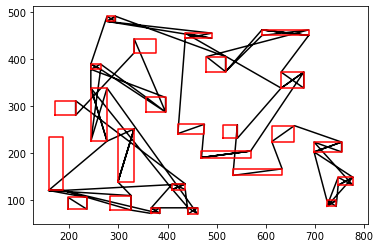

tensor([ 1.,  9.,  9.,  9., 19., 10.,  2., 10.,  4.,  1.,  4., 19.,  4., 16.,
         3.,  3., 16.,  3., 24.,  7., 24., 24., 11., 11., 18., 18., 18., 12.,
        15., 21., 21., 23., 12., 12., 17.,  5., 17., 22., 22.,  5.,  5., 23.,
         8.,  0., 14., 20., 23., 13., 13., 20.,  6.,  6., 20., 13.,  6.],
       device='cuda:0')
epoch:19, batch:400/500, reward:11398.7607421875


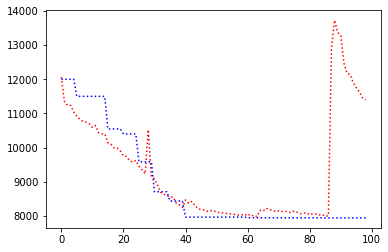

record the last path to gazebo for showing up


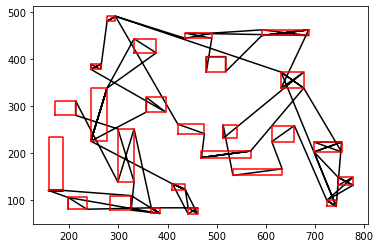

tensor([ 1.,  9.,  9.,  9.,  1., 19., 10., 10.,  3.,  3.,  4., 19.,  4.,  3.,
        16.,  4., 24., 18., 11.,  2., 24., 12., 18., 24., 18., 16., 21., 15.,
        21., 11.,  7., 12., 12., 17., 17., 22., 22.,  5.,  5.,  5., 23.,  8.,
         0., 23., 23.,  6., 14.,  6., 13., 13.,  6., 20., 20., 13., 20.],
       device='cuda:0')
epoch:19, batch:500/500, reward:11147.4697265625


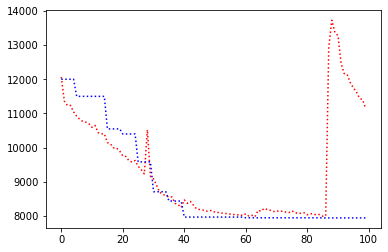

record the last path to gazebo for showing up


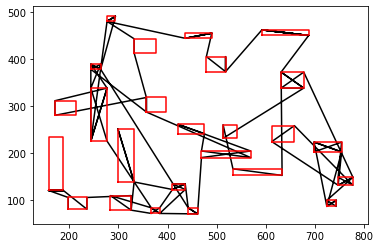

R_val =  tensor(11553.9785, device='cuda:0')
C_val =  tensor(7941.6318, device='cuda:0')
Avg Actor 11553.978515625 --- Avg Critic 7941.6318359375
Epoch: 19, epoch time: 11.794min, tot time: 0.164day, L_actor: 11553.979, L_critic: 7941.632, update: False
Save Checkpoints
tensor([ 1.,  9.,  9.,  9.,  1.,  4., 10., 24.,  2., 10.,  4.,  4., 19.,  3.,
        15.,  3., 16., 19., 16.,  3., 24., 18., 12., 11., 24., 11., 18., 12.,
        12., 18.,  7., 17., 22., 22., 17.,  5.,  8., 21., 21.,  5.,  5., 23.,
         0., 14., 23., 23., 13., 13., 13.,  6.,  6., 20.,  6., 20., 20.],
       device='cuda:0')
epoch:20, batch:100/500, reward:11249.181640625


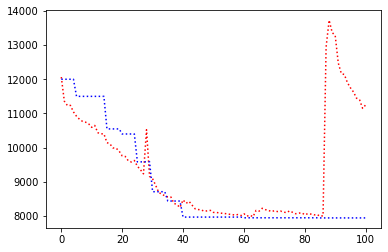

record the last path to gazebo for showing up


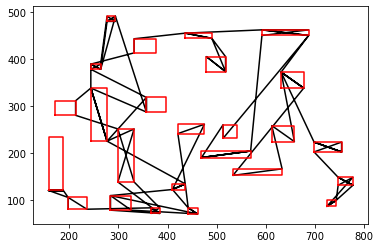

tensor([ 1.,  9.,  9.,  9.,  1., 19., 10.,  2., 24., 24., 24., 10., 16., 19.,
        16.,  4.,  3.,  3.,  4.,  4.,  3., 22., 12., 12., 18.,  7., 18., 12.,
        18., 11., 11.,  5., 15., 21., 21., 22., 17.,  5., 17.,  5., 23.,  0.,
         8., 14., 13.,  6., 23., 23., 20., 20., 20.,  6.,  6., 13., 13.],
       device='cuda:0')
epoch:20, batch:200/500, reward:11150.2939453125


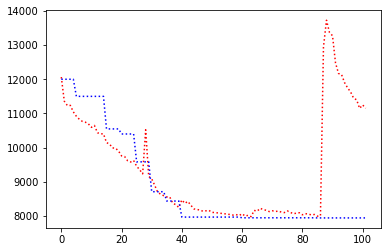

record the last path to gazebo for showing up


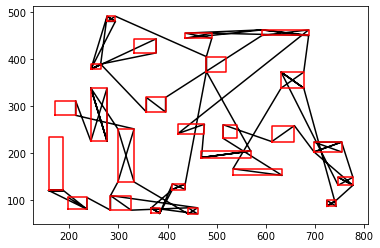

tensor([ 1.,  9.,  9.,  9.,  1., 19., 10., 24., 24., 24.,  2., 10., 16.,  3.,
         4.,  3., 16., 19.,  4.,  4.,  3., 11., 11., 12., 18., 12., 18., 12.,
        18.,  7., 15., 21., 21., 22., 22., 17., 17.,  5.,  5.,  5., 23.,  8.,
         0., 14., 23., 23., 20., 13., 13., 13., 20., 20.,  6.,  6.,  6.],
       device='cuda:0')
epoch:20, batch:300/500, reward:10988.10546875


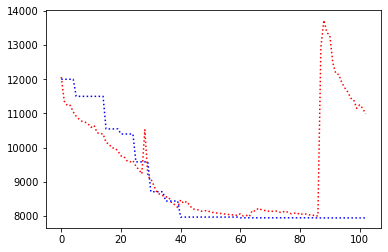

record the last path to gazebo for showing up


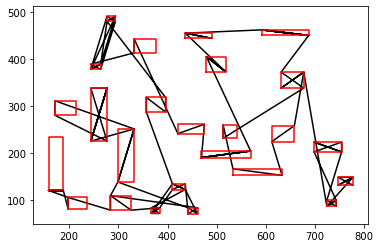

tensor([ 1.,  9.,  9.,  9.,  5.,  2., 24., 24., 24., 10., 10., 11., 11., 18.,
        18., 18.,  1.,  4.,  3., 15.,  3., 19.,  3., 19., 16., 16.,  4.,  4.,
        21., 21., 22., 12., 12., 12.,  7.,  5., 17., 17., 22.,  5., 23.,  8.,
         0., 14., 23., 23., 20., 13., 13.,  6., 13.,  6.,  6., 20., 20.],
       device='cuda:0')
epoch:20, batch:400/500, reward:11074.978515625


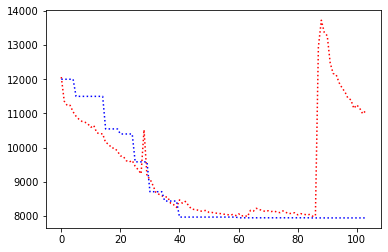

record the last path to gazebo for showing up


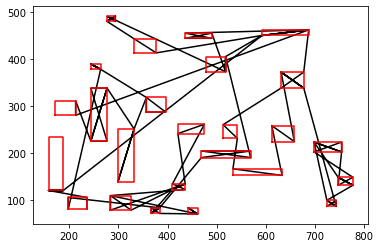

tensor([ 1.,  9.,  9.,  9.,  1., 19., 10., 10., 19.,  4.,  4.,  4., 16., 21.,
        16.,  3.,  3.,  3., 21., 15., 24.,  2., 24., 18., 11., 24., 18., 12.,
        12., 12., 11., 18.,  7., 22., 17., 17., 22.,  5.,  5.,  5., 23.,  8.,
        23., 23.,  0., 14., 13.,  6.,  6.,  6., 20., 13., 13., 20., 20.],
       device='cuda:0')
epoch:20, batch:500/500, reward:11199.5546875


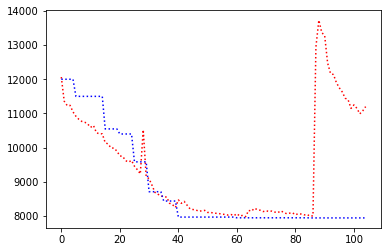

record the last path to gazebo for showing up


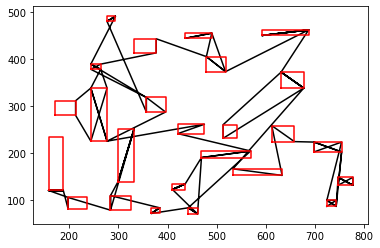

R_val =  tensor(11567.6533, device='cuda:0')
C_val =  tensor(7941.6318, device='cuda:0')
Avg Actor 11567.6533203125 --- Avg Critic 7941.6318359375
Epoch: 20, epoch time: 11.663min, tot time: 0.172day, L_actor: 11567.653, L_critic: 7941.632, update: False
Save Checkpoints
tensor([ 1.,  1.,  9., 19.,  9., 19., 10.,  9.,  3., 10., 11.,  3.,  4.,  3.,
        16., 16.,  4.,  4., 21., 21., 15., 24., 24., 12., 18., 11., 18., 18.,
        24., 12.,  7.,  2., 17., 17., 12., 22., 22., 23.,  5.,  5.,  5., 23.,
        23.,  8.,  0., 14., 20., 13., 13., 13.,  6., 20.,  6., 20.,  6.],
       device='cuda:0')
epoch:21, batch:100/500, reward:11294.271484375


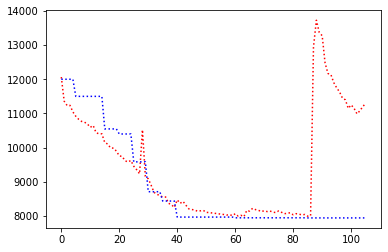

record the last path to gazebo for showing up


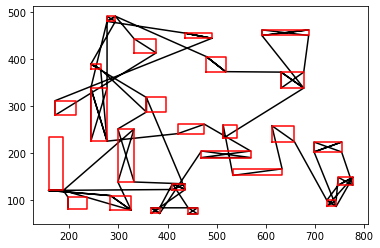

tensor([ 1.,  9.,  9.,  1.,  9., 10., 19.,  3., 16.,  3., 19.,  4.,  4., 10.,
        24.,  4.,  3., 16., 21., 15., 24.,  2., 24., 11., 11., 18., 12., 18.,
        18., 12., 12.,  7., 17., 17., 22., 21.,  8., 22.,  5.,  5.,  5., 23.,
        23., 23., 14.,  0.,  6., 13., 13., 13., 20.,  6., 20.,  6., 20.],
       device='cuda:0')
epoch:21, batch:200/500, reward:11246.302734375


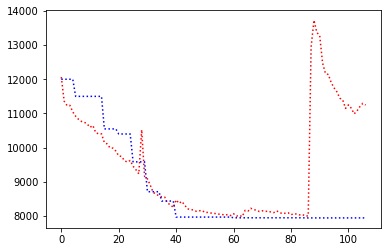

record the last path to gazebo for showing up


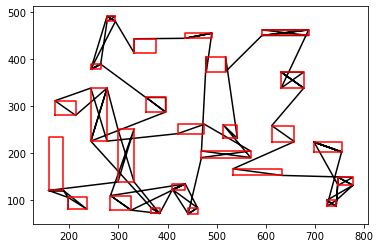

tensor([ 1.,  9.,  9.,  1.,  9., 19.,  3.,  3., 19., 10., 10., 16.,  3., 16.,
         4.,  4.,  4., 21., 21., 15., 11., 11., 22., 24., 24., 24., 18.,  2.,
         7., 18., 17., 12., 12., 18., 12., 17., 22.,  5.,  5.,  5., 23., 23.,
        23.,  8.,  0., 14., 13.,  6., 13., 20., 13.,  6.,  6., 20., 20.],
       device='cuda:0')
epoch:21, batch:300/500, reward:11062.37109375


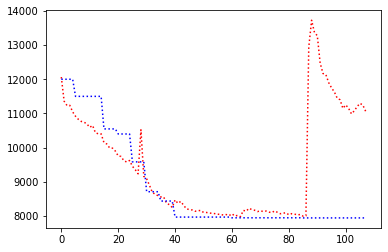

record the last path to gazebo for showing up


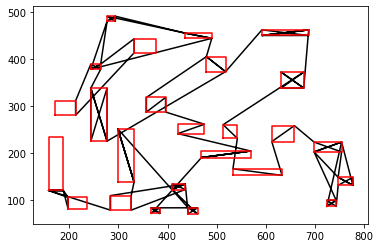

tensor([ 1.,  9.,  9.,  9.,  1., 19., 10., 10., 19.,  3.,  4.,  4.,  4.,  3.,
        16.,  3., 16., 15., 21., 21.,  8., 24.,  2., 24., 24., 18., 12., 18.,
        12., 18., 12.,  7., 11., 11., 17., 17., 22., 22.,  5.,  5.,  5., 23.,
        23., 23., 13., 14.,  0., 13., 20.,  6., 13., 20., 20.,  6.,  6.],
       device='cuda:0')
epoch:21, batch:400/500, reward:11021.7578125


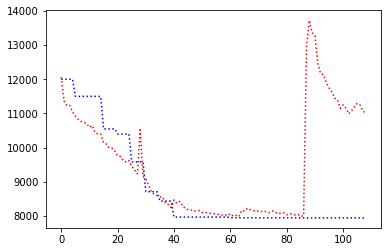

record the last path to gazebo for showing up


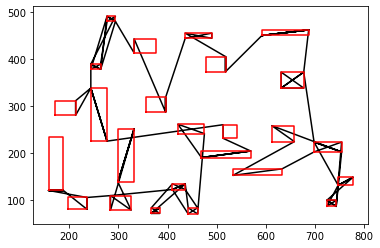

tensor([ 1.,  9.,  9.,  1.,  9.,  4., 16., 16., 19., 10.,  3.,  3., 19.,  3.,
         4., 10.,  4., 24., 11., 15., 21., 24., 11.,  2., 18., 24., 18., 18.,
        12.,  7., 12., 12., 17., 21.,  8., 23., 17., 22., 22., 23., 23., 14.,
         0.,  5.,  5.,  5.,  6., 13.,  6., 13., 20., 13., 20.,  6., 20.],
       device='cuda:0')
epoch:21, batch:500/500, reward:11144.0625


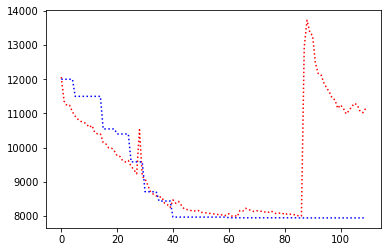

record the last path to gazebo for showing up


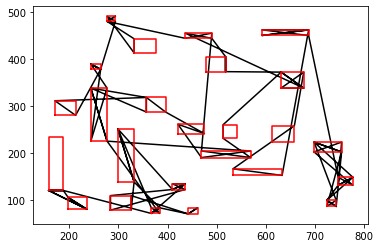

R_val =  tensor(11323.4248, device='cuda:0')
C_val =  tensor(7941.6318, device='cuda:0')
Avg Actor 11323.4248046875 --- Avg Critic 7941.6318359375
Epoch: 21, epoch time: 11.669min, tot time: 0.180day, L_actor: 11323.425, L_critic: 7941.632, update: False
Save Checkpoints


In [ ]:
import yaml
from torch.distributions.categorical import Categorical
# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm_notebook
import torch.nn.functional as F
####### my own import file ##########
from listofpathpoint import input_handler
import cnc_input
import copy
#from hybrid_models import HPN
####### my own import file ##########
'''
so, the models we have are TransEncoderNet,
                            Attention
                            LSTM
                            HPN
each one have initial parameters and the forward part, 
once we have the forward part, the back propagation will 
finished automatically by pytorch  
'''
TOL = 1e-3
TINY = 1e-15
learning_rate = 1e-4   #learning rate
B = 128          #batch size
B_valLoop = 1
steps = 500
n_epoch = 100       # epochs
map_number = 0
record_actor = []
record_critic = []
dimension = 4
speed_of_nozzle = 30
range_of_wait = 20
scale_of_the_map = (800,500,speed_of_nozzle*range_of_wait)

print('======================')
print('prepare to train')
print('======================')
print('Hyper parameters:')
print('learning rate', learning_rate)
print('batch size', B)
print('steps', steps)
print('epoch', n_epoch)
print('======================')

'''
instantiate a training network and a baseline network
'''


try:
    del Actor  # remove existing model
    del Critic # remove existing model
except:
    pass
Actor = HPN(n_feature = dimension, n_hidden = 128)
Critic = HPN(n_feature = dimension, n_hidden = 128)
optimizer = optim.Adam(Actor.parameters(), lr=learning_rate)

# Putting Critic model on the eval mode
Actor = Actor.to(device)
Critic = Critic.to(device)
Critic.eval()

epoch_ckpt = 0
tot_time_ckpt = 0

val_mean = []
val_std = []
maplist = ['10&15data/25_chips/25_1.json'
          ,'10&15data/25_chips/25_1.json','10&15data/25_chips/25_1.json'\
          ,'10&15data/25_chips/25_1.json','10&15data/25_chips/25_1.json'\
          ,'10&15data/25_chips/25_1.json'
          ]
          
plot_performance_train = []
plot_performance_baseline = []
# recording the result of the resent epoch makes it available for future
#*********************# Uncomment these lines to load the previous check point
"""
checkpoint_file = "checkpoint/mutimap_20.pkl"
checkpoint = torch.load(checkpoint_file, map_location=device)
epoch_ckpt = checkpoint['epoch'] + 1
tot_time_ckpt = checkpoint['tot_time']
plot_performance_train = checkpoint['plot_performance_train']
plot_performance_baseline = checkpoint['plot_performance_baseline']
Critic.load_state_dict(checkpoint['model_baseline'])
Actor.load_state_dict(checkpoint['model_train'])
optimizer.load_state_dict(checkpoint['optimizer'])

print('Re-start training with saved checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))
"""

#***********************# Uncomment these lines to load the previous check point

# Main training loop
# The core training concept mainly upon Sampling from the actor
# then taking the greedy action from the critic

start_training_time = time.time()
time_stamp = datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S") # Load the time stamp

C = 0       # baseline => the object which the actor can compare
R = 0       # reward
C_critic = torch.Tensor([12000])
if torch.cuda.is_available():
    C_critic = C_critic.cuda()
temp = input_handler(maplist[map_number])
X_temp, mask_list_num = temp.final_ver_points()
print(X_temp)
print(mask_list_num)
#change the waiting time to the distance that we can measure
size = len(X_temp)
zero_to_bsz = torch.arange(B, device = device) # a list contains 0 to (batch size -1)
# load the GCN table
GCN_table = y_table.repeat(B,1,1)

for corner in X_temp:
    corner[dimension -2] *= speed_of_nozzle
size_rec = mask_list_num[-1]
print(size_rec)

X_temp = torch.FloatTensor(X_temp)
visit_count_initial = X_temp[:,dimension-1]
visit_count_rec = []
for i in range(0,len(visit_count_initial),4):
    visit_count_rec.append(int(visit_count_initial[i]))
X = X_temp.repeat(B,1,1)
if torch.cuda.is_available():
    X = X.cuda()

for epoch in range(0, n_epoch):
    # re-start training with saved checkpoint
    epoch += epoch_ckpt # adding the number of the former epochs
    # Train the model for one epoch
    start = time.time() # record the starting time
    Actor.train() 
    path_gazebo = []
    for i_all in range(1, steps+1): # 1 ~ 2500 steps
        # mask some points that are not the first visited points
        if torch.cuda.is_available():
            R = torch.zeros(B).cuda()
            reward_recorder = torch.zeros(B,size_rec).cuda()
            idx_recorder = torch.zeros(B,size_rec).cuda()
            logprobs = 0
            reward = torch.zeros(B).cuda()
            mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        else:
            R = torch.zeros(B)
            reward_recorder = torch.zeros(B,size_rec)
            idx_recorder = torch.zeros(B,size_rec)
            logprobs = 0
            reward = torch.zeros(B)
            mask = torch.zeros(B,size) # use mask to make some points impossible to choose
        x = torch.zeros(B,dimension)# Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None        # set Y_ini to the out corner
        Transcontext = None
        Y0 = None
        choosen_idx = None
        visit_count = visit_count_initial.repeat(B,1)
        visit_time_count_initial = torch.zeros(len(visit_count_initial))
        visit_time_count = visit_time_count_initial.repeat(B,1)
        if torch.cuda.is_available():
            visit_count = visit_count.cuda()
        # Actor Sampling phase
        for k in range(size_rec):
            if k ==0:
                Y = X.view(B,size,dimension)
            context, Transcontext, output, output_GCN, h, c, _ = Actor(context,Transcontext,x=x, X_all=X,h=h,
                                                           c=c, mask=mask, choosen_idx=choosen_idx, 
                                                                       GCN_table=GCN_table,epoch=epoch+1)
            sampler = torch.distributions.Categorical(output_GCN)
            idx = sampler.sample()
            idx_recorder[:,k] = (idx/4).type(torch.long)
            #prepare for the back propagation of pytorch
            Y, reward, Y0, x, choosen_idx = rectangle_process(temp, idx,Y,Y0,mask,k,B,i_all,path_gazebo,
                                                visit_count, visit_time_count, if_actor=True)
            R += reward
            reward_recorder[:,k] = R
            logprobs += torch.log(output[zero_to_bsz, idx.data] + TINY)
            
        #now is the time to check if any trajectory should be punished due to waiting on the same rectangle

        trajec_count = 0
        if i_all%100 ==0:
            print(idx_recorder[0])
        for path_time in zip(idx_recorder,reward_recorder):
            idx_time = zip(path_time[0],path_time[1])
            idx_time = sorted(idx_time, key=lambda x: x[0])
            total_idx = 0
            extra_waiting_time = 0
            for item in visit_count_rec:
                compare_list = []
                if item>1:
                    for i in range(int(item)):
                        compare_list.append(idx_time[int(total_idx + i)][1])
                    compare_list.sort(reverse=True)
                    total_idx += item
                    for i in range(len(compare_list)-1):
                        dis_step = compare_list[i] - compare_list[i+1]
                        dry_time = (range_of_wait/2)*speed_of_nozzle
                        if (dis_step) < (dry_time):
                            extra_waiting_time += dry_time - dis_step
                else:
                    total_idx += item
            R[trajec_count] += extra_waiting_time
            trajec_count+=1
                    
                
        
# # critic baseline phase, use the baseline to compute the actual reward of agent at that time
#         if torch.cuda.is_available():
#             C = torch.zeros(B).cuda()
#             reward_recorder = torch.zeros(B,size_rec).cuda()
#             idx_recorder = torch.zeros(B,size_rec).cuda()
#             baseline = torch.zeros(B).cuda()
#             mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose

#         else:
#             C = torch.zeros(B)
#             reward_recorder = torch.zeros(B,size_rec)
#             idx_recorder = torch.zeros(B,size_rec)
#             baseline = torch.zeros(B)
#             mask = torch.zeros(B,size) # use mask to make some points impossible to choose
#         x = torch.zeros(B,dimension)#Y[:,0,:] #set the first point to x
#         h = None
#         c = None
#         context = None
#         Transcontext = None
#         C0 = None
#         visit_count = visit_count_initial.repeat(B,1)
#         if torch.cuda.is_available():
#             visit_count = visit_count.cuda()
#         # compute tours for baseline without grad "Cause we want to fix the weights for the critic"
#         with torch.no_grad():
#             for k in range(size_rec):     
#                 Y = X.view(B,size,dimension)
#                 #check if all the points to be masked,if so, raise the total reward R, and check again
#                 context, Transcontext, output, h, c, _ = Critic(context,Transcontext,x=x, X_all=X,h=h,
#                                                                 c=c, mask=mask)
#                 idx = torch.argmax(output, dim=1) # ----> greedy baseline critic
#                 idx_recorder[:,k] = (idx/4).type(torch.long)
#                 # prepare for the back propagation of pytorch
#                 baseline, C0,x = rectangle_process(temp,idx,Y,C0, mask,k,B,i_all,path_gazebo,
#                                                    visit_count,if_actor=False)
#                 C += baseline
#                 reward_recorder[:,k] = C
#             #now is the time to check if any trajectory should be punished due to waiting on the same rectangle

#             trajec_count = 0
#             for path_time in zip(idx_recorder,reward_recorder):
#                 idx_time = zip(path_time[0],path_time[1])
#                 idx_time = sorted(idx_time, key=lambda x: x[0])
#                 total_idx = 0
#                 extra_waiting_time = 0
#                 for item in visit_count_rec:
#                     compare_list = []
#                     if item>1:
#                         for i in range(int(item)):
#                             compare_list.append(idx_time[int(total_idx + i)][1])
#                         compare_list.sort(reverse=True)
#                         total_idx += item
#                         for i in range(len(compare_list)-1):
#                             dis_step = compare_list[i] - compare_list[i+1]
#                             dry_time = (range_of_wait/2)*speed_of_nozzle
#                             if (dis_step) < (dry_time):
#                                 extra_waiting_time += dry_time - dis_step
#                     else:
#                         total_idx += item
#                 C[trajec_count] += extra_waiting_time
#                 trajec_count+=1
        ###################
        # Loss and backprop handling 
        ###################
        loss = torch.mean((R - C_critic[0]) * logprobs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i_all % 100 == 0:
            print("epoch:{}, batch:{}/{}, reward:{}".format(epoch, i_all, steps,R.mean().item()))
            record_actor.append(R.mean().tolist())
            record_critic.append(C_critic[0].tolist())
            plt.plot(record_actor,'r:')
            plt.plot(record_critic,'b:')
            plt.show()
        if i_all % 100 == 0:
            print("record the last path to gazebo for showing up")
            #starting to show the path on simulated enviroment of cnc_machine 
            the_resent_path = temp.zig_zag_path(path_gazebo,mask_list_num)
            data = {'path':the_resent_path}
            data_1 = {'corners':path_gazebo}
            pathpoints_dir = os.path.join("pathpoints")
            if not os.path.exists(pathpoints_dir):
                os.makedirs(pathpoints_dir)
            name = 'pathpoints/path_points '+str(i)+'.yaml'
            with open(name, 'w') as file:
                documents = yaml.dump(data,file)
                documents = yaml.dump(data_1,file)
            path_gazebo = []
    time_one_epoch = time.time() - start #recording the work time of one epoch
    time_tot = time.time() - start_training_time + tot_time_ckpt
    ###################
    # Evaluate train model and baseline 
    # in this phase we just solve random instances with the actor and the critic
    # compare this soluation if we get any improvment we'll transfer the actor's
    # weights into the critic
    ###################
    # putting the actor in the eval mode
    Actor.eval()
    
    mean_tour_length_actor = 0
    mean_tour_length_critic = 0

    for step in range(0,B_valLoop):
        
        # compute tour for model and baseline
        # mask some points that are not the first visited points
        if torch.cuda.is_available():
            R = torch.zeros(B).cuda()
            reward_recorder = torch.zeros(B,size_rec).cuda()
            idx_recorder = torch.zeros(B,size_rec).cuda()
            reward = torch.zeros(B).cuda()
            mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        else:
            R = torch.zeros(B)
            reward_recorder = torch.zeros(B,size_rec)
            idx_recorder = torch.zeros(B,size_rec)
            reward = torch.zeros(B)
            mask = torch.zeros(B,size) # use mask to make some points impossible to choose
        x = torch.zeros(B,dimension)# Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None        # set Y_ini to the out corner
        Transcontext = None
        Y0 = None
        choosen_idx = None
        visit_count = visit_count_initial.repeat(B,1)
        visit_time_count_initial = torch.zeros(len(visit_count_initial))
        visit_time_count = visit_time_count_initial.repeat(B,1)
        if torch.cuda.is_available():
            visit_count = visit_count.cuda()

        with torch.no_grad():
            for k in range(size_rec):
                if k==0:
                    Y = X.view(B,size,dimension)
                context, Transcontext, output, output_GCN, h, c, _ = Actor(context,Transcontext,x=x, X_all=X,h=h,
                                                               c=c, mask=mask,choosen_idx=choosen_idx,GCN_table=GCN_table,epoch=epoch+1)
                idx = torch.argmax(output_GCN, dim=1)
                idx_recorder[:,k] = (idx/4).type(torch.long)
                #prepare for the back propagation of pytorch
                Y, reward, Y0, x, choosen_idx = rectangle_process(temp, idx,Y,Y0,mask,k,B,i,path_gazebo,
                                                    visit_count, visit_time_count, if_actor=False)
                R += reward
                reward_recorder[:,k] = R
            #now is the time to check if any trajectory should be punished due to waiting on the same rectangle

            trajec_count = 0
            for path_time in zip(idx_recorder,reward_recorder):
                idx_time = zip(path_time[0],path_time[1])
                idx_time = sorted(idx_time, key=lambda x: x[0])
                total_idx = 0
                extra_waiting_time = 0
                for item in visit_count_rec:
                    compare_list = []
                    if item>1:
                        for i in range(int(item)):
                            compare_list.append(idx_time[int(total_idx + i)][1])
                        compare_list.sort(reverse=True)
                        total_idx += item
                        for i in range(len(compare_list)-1):
                            dis_step = compare_list[i] - compare_list[i+1]
                            dry_time = (range_of_wait/2)*speed_of_nozzle
                            if (dis_step) < (dry_time):
                                extra_waiting_time += dry_time - dis_step
                    else:
                        total_idx += item
                R[trajec_count] += extra_waiting_time
                trajec_count+=1
            print('R_val = ',R[0])
        if torch.cuda.is_available():
            C = torch.zeros(B).cuda()
            reward_recorder = torch.zeros(B,size_rec).cuda()
            idx_recorder = torch.zeros(B,size_rec).cuda()
            baseline = torch.zeros(B).cuda()
            mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        else:
            C = torch.zeros(B)
            reward_recorder = torch.zeros(B,size_rec)
            idx_recorder = torch.zeros(B,size_rec)
            baseline = torch.zeros(B)
            mask = torch.zeros(B,size) # use mask to make some points impossible to choose
        x = torch.zeros(B,dimension)#Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None
        Transcontext = None
        C0 = None
        choosen_idx = None
        visit_count = visit_count_initial.repeat(B,1)
        visit_time_count_initial = torch.zeros(len(visit_count_initial))
        visit_time_count = visit_time_count_initial.repeat(B,1)
        if torch.cuda.is_available():
            visit_count = visit_count.cuda()
        # compute tours for baseline without grad "Cause we want to fix the weights for the critic"
        with torch.no_grad():
            for k in range(size_rec): 
                if k ==0:
                    Y = X.view(B,size,dimension)
                #check if all the points to be masked,if so, raise the total reward R, and check again
                context, Transcontext, output, output_GCN, h, c, _ = Critic(context,Transcontext,x=x, X_all=X,h=h,
                                                                c=c, mask=mask, choosen_idx=choosen_idx, GCN_table=GCN_table,epoch=epoch+1)
                idx = torch.argmax(output_GCN, dim=1) # ----> greedy baseline critic
                idx_recorder[:,k] = (idx/4).type(torch.long)
                # prepare for the back propagation of pytorch
                Y, baseline, C0, x, choosen_idx = rectangle_process(temp,idx,Y,C0, mask,k,B,i,path_gazebo,
                                                   visit_count, visit_time_count, if_actor=False)
                C += baseline
                reward_recorder[:,k] = C
                    #now is the time to check if any trajectory should be punished due to waiting on the same rectangle

            trajec_count = 0
            for path_time in zip(idx_recorder,reward_recorder):
                idx_time = zip(path_time[0],path_time[1])
                idx_time = sorted(idx_time, key=lambda x: x[0])
                total_idx = 0
                extra_waiting_time = 0
                for item in visit_count_rec:
                    compare_list = []
                    if item>1:
                        for i in range(int(item)):
                            compare_list.append(idx_time[int(total_idx + i)][1])
                        compare_list.sort(reverse=True)
                        total_idx += item
                        for i in range(len(compare_list)-1):
                            dis_step = compare_list[i] - compare_list[i+1]
                            dry_time = (range_of_wait/2)*speed_of_nozzle
                            if (dis_step) < (dry_time):
                                extra_waiting_time += dry_time - dis_step
                    else:
                        total_idx += item
                C[trajec_count] += extra_waiting_time
                trajec_count+=1
            print('C_val = ',C[0])
        C_critic = [C[0]]
        mean_tour_length_actor  += R.mean().item()
        mean_tour_length_critic += C.mean().item()

    mean_tour_length_actor  =  mean_tour_length_actor  / B_valLoop
    mean_tour_length_critic =  mean_tour_length_critic / B_valLoop
    # evaluate train model and baseline and update if train model is better

    update_baseline = mean_tour_length_actor + TOL < mean_tour_length_critic

    print('Avg Actor {} --- Avg Critic {}'.format(mean_tour_length_actor,mean_tour_length_critic))

    if update_baseline:
        Critic.load_state_dict(Actor.state_dict())
        C_critic = [R[0]]
        print('My actor is going on the right road Hallelujah :) Updated')
    ###################
    # Valdiation train model and baseline on 1k random TSP instances
    ###################
    # erased by daniel due to the 1K tsp is not the scale I want to train  

    # For checkpoint
    plot_performance_train.append([(epoch+1), mean_tour_length_actor])
    plot_performance_baseline.append([(epoch+1), mean_tour_length_critic])
    # compute the optimally gap ==> this is interesting because there is no LKH or other optimal algorithms 
    # for the problem like this rectangle characterized map
    mystring_min = 'Epoch: {:d}, epoch time: {:.3f}min, tot time: {:.3f}day, L_actor: {:.3f}, L_critic: {:.3f}, update: {}'.format(
        epoch, time_one_epoch/60, time_tot/86400, mean_tour_length_actor, mean_tour_length_critic, update_baseline)

    print(mystring_min)
    print('Save Checkpoints')

    # Saving checkpoint
    checkpoint_dir = os.path.join("checkpoint")

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    torch.save({
        'epoch': epoch,
        'time': time_one_epoch,
        'tot_time': time_tot,
        'loss': loss.item(),
        'plot_performance_train': plot_performance_train,
        'plot_performance_baseline': plot_performance_baseline,
        'model_baseline': Critic.state_dict(),
        'model_train': Actor.state_dict(),
        'optimizer': optimizer.state_dict(),
        },'{}.pkl'.format(checkpoint_dir + "/checkpoint_" + time_stamp + "-n{}".format(size) + "-gpu{}".format(gpu_id)))


  




                
            
                
        
                        

In [ ]:
import torch
index = int(9.34)
table = [[1,2],[3,4]]
table_1 = [[3,44],[5,6]]
table = torch.as_tensor(table)
table_1 = torch.as_tensor(table_1)
result = torch.maximum(table_1[:,0],table_1[:,1])
print(result)

In [6]:
import torch
t = torch.ones(10,2,2,2)
x = torch.ones(10,2,2)
k = x.unsqueeze(1)*2
x = x.unsqueeze(2)
print(x.shape)
print(k.shape)
print(t.shape)
X = t+x+k
print(X)



torch.Size([10, 2, 1, 2])
torch.Size([10, 1, 2, 2])
torch.Size([10, 2, 2, 2])
tensor([[[[4., 4.],
          [4., 4.]],

         [[4., 4.],
          [4., 4.]]],


        [[[4., 4.],
          [4., 4.]],

         [[4., 4.],
          [4., 4.]]],


        [[[4., 4.],
          [4., 4.]],

         [[4., 4.],
          [4., 4.]]],


        [[[4., 4.],
          [4., 4.]],

         [[4., 4.],
          [4., 4.]]],


        [[[4., 4.],
          [4., 4.]],

         [[4., 4.],
          [4., 4.]]],


        [[[4., 4.],
          [4., 4.]],

         [[4., 4.],
          [4., 4.]]],


        [[[4., 4.],
          [4., 4.]],

         [[4., 4.],
          [4., 4.]]],


        [[[4., 4.],
          [4., 4.]],

         [[4., 4.],
          [4., 4.]]],


        [[[4., 4.],
          [4., 4.]],

         [[4., 4.],
          [4., 4.]]],


        [[[4., 4.],
          [4., 4.]],

         [[4., 4.],
          [4., 4.]]]])
